In [1]:
include("basin_hopping.jl")
using Plots, Polynomials, CubicSplines, LaTeXStrings, Calculus, Optim

# Curve Fitting With Basin Hopping

Convex problems have a multitude of "nice" properties, not the least of which is the assurance that any point where $\nabla f = 0$ gives us a global optimal solution. This gives rise to certain certificates of optimality which may be used to be sure that a solution $x$ is optimal.

Conversely, non-convex problems do not have these nice properties. We have no guarantee that any local solution is the global solution and in fact, there may be infinitely many global solutions.

However, many real world problems are non-convex, making finding a means of optimizing them all the more important. For example, consider the following sample data $(\overline{x}_1, \overline{y}_1),\ldots,(\overline{x}_k, \overline{y}_k)$ and suppose we want to fit it to the model:

$$
f(x) = a\sin(bx) + b\cos(ax)
$$

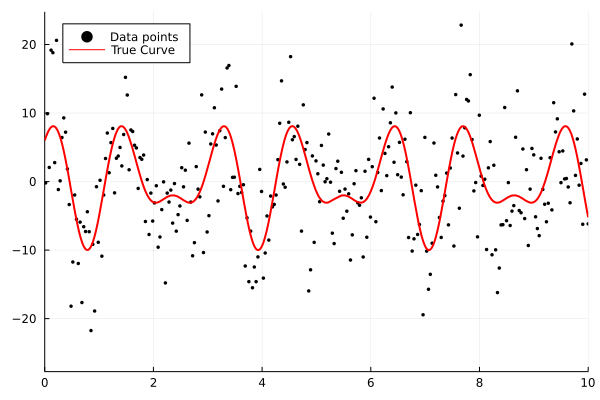

In [2]:
#Actual parameters
a = 4.0
b = 6.0

f(x) = a*sin(b*x) + b*cos(a*x)

#Generate noisy data
datasize = 600
variation = 6
x_range = range(-10, 10, length=datasize)
y_range = f.(x_range) + randn(datasize)*variation

scatter(x_range, y_range, label = "Data points", color=:black, markersize = 2)
plot!(f, legend=:topleft, label = "True Curve", color=:red, xrange = (0, 10), linewidth = 2)

To solve such a problem, we would want minimize the value $L(a, b) = \|\mathbf{\overline{y}} - \mathbf{y}\|_2^2$, where vector $\mathbf{\overline{y}}$ contains each $\overline{y}$ and vector $\mathbf{y} = a\sin(bx) + b\cos(ax),\;x\in\{\overline{x}_1,\ldots,\overline{x}_k\}$. Graphing $L$, we can clearly see that this objective is non-convex.

In [3]:
f_params(_a, _b) = [_a*sin(_b*x) + _b*cos(_a*x) for x in x_range]
f_params(p) = f_params(p...)
Loss(p) = norm(y_range - f_params(p))
Loss_plotter(_a, _b) = Loss([_a, _b]);
aa = -10:.05:10
bb = -10:.05:10

contour(aa, bb, Loss_plotter, fill=true, title = "Loss Function")
plot!(xlabel=L"a", ylabel=L"b", size=(600,600), legend=:none)
scatter!([a], [b], color=:white, label = "Known Solution", markersize = 3)

### Basin Hopping Overview

Basin Hopping is a practical approach for non-convex optimization. Though it lacks any proofs of convergence, this method is one of the most common global optimization techniques used in practice, due to its speed and ease of dimensional generalization.

Its premise is simple: start somewhere in the domain of objective $f$ and minimize locally. Then take sample points in the neighborhood of this local solution.

We may either take these points as they are or optimize the objective from each and pick the lowest solution. From these collection of points, we select one to be our next starting point. We select based on the following criterion called the Metropolis Acceptance Criterion. For previous solution $x^*$, current solution $\hat{x}^*$, and random point $\xi\in [0,1]$, we pick the next starting point based on the following:

$$
x^* = \begin{cases} \hat{x}^*,\; f(\hat{x}^*) < f(x^*) \text{ or } \xi \leq \exp\left(\min\left(0, \frac{f(x^*)-f(\hat{x}^*)}{T}\right)\right) \\ x^*,\;\text{ else} \end{cases}
$$

Where $T\in (0, 1]$ is a parameter. So if $f(\hat{x}^*) < f(x^*)$, then we accept $\hat{x}^*$ automatically. Otherwise, we accept it according to the probability curve $\exp\left(\min\left(0, \frac{f(x^*)-f(\hat{x}^*)}{T}\right)\right)$. This is visualized below:

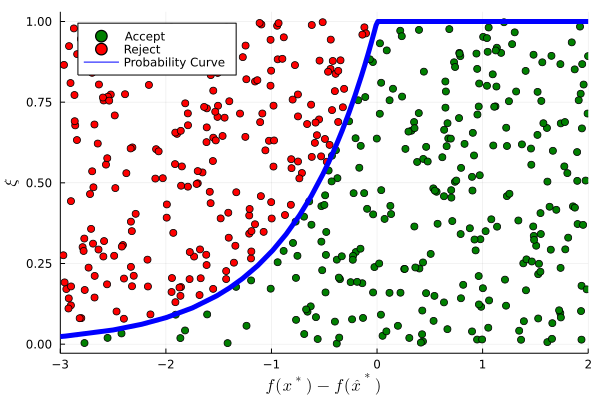

In [4]:
old_val = 1.0
T = 0.8

dd(diff) = exp(min(0, (diff)/T))

x_range1 = Float64[]
x_range2 = Float64[]
ξ_accept = Float64[]
ξ_reject = Float64[]
for i = 1:500
    ξ = rand()
    x = 5*rand() - 3
    if ξ < dd(x)
        append!(ξ_accept, ξ)
        append!(x_range1, x)
    else
        append!(ξ_reject, ξ)
        append!(x_range2, x)
    end
end

plot(legend=:topleft, xlims = (-3, 2), xaxis = L"f(x^*)-f(\hat{x}^*)", yaxis = L"\xi")
scatter!(x_range1, ξ_accept, color=:green, label = "Accept")
scatter!(x_range2, ξ_reject, color=:red, label = "Reject")
plot!(dd, label = "Probability Curve", linewidth = 5, color=:blue)

We may also adjust the length $\ell$ of the search neighborhood by tracking the acceptance rate. If the acceptance rate is less then our target, then the algorithm is returning few better solutions so we scale $\ell$ up to search a larger area. Conversely, if the acceptance rate is too high, than we may be trapped in a basin so scale $\ell$ down until the target acceptance rate is reached.

### Problem Formulation

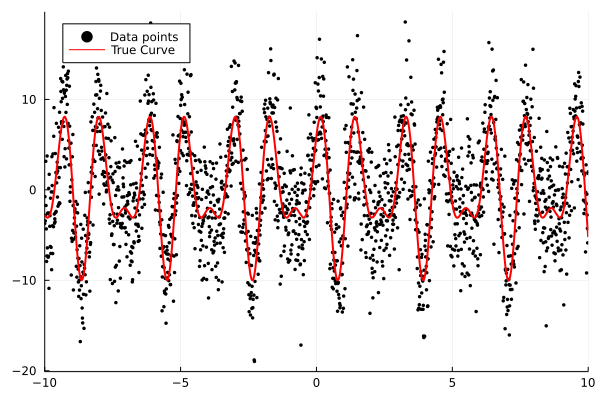

In [5]:
#Actual parameters
a = 4.0
b = 6.0

f(x) = a*sin(b*x) + b*cos(a*x)

#Generate noisy data
datasize = 2048
variation = 4
x_range = range(-10, 10, length=datasize)
y_range = f.(x_range) + randn(datasize)*variation

scatter(x_range, y_range, label = "Data points", color=:black, markersize = 2)
plot!(f, legend=:topleft, label = "True Curve", color=:red, xrange = (-10, 10), linewidth = 2)

So our goal is to find the best fit by minimizing the loss $L(a, b) = \|\mathbf{\overline{y}} - \mathbf{y}\|_2^2$. We will try to solve the problem in $2$ ways. In the first way, we will first assume we know what the function structure is. In the second way, we will not.

### Finding Best Fit When We Know The Problem Structure

Firstly, consider the case when we know that our original $f$ is in the form

$$
f(x) = a\sin(bx) + b\cos(ax)
$$

If this is the case, then we can simply construct our loss function as a function of $a$ and $b$ like so:

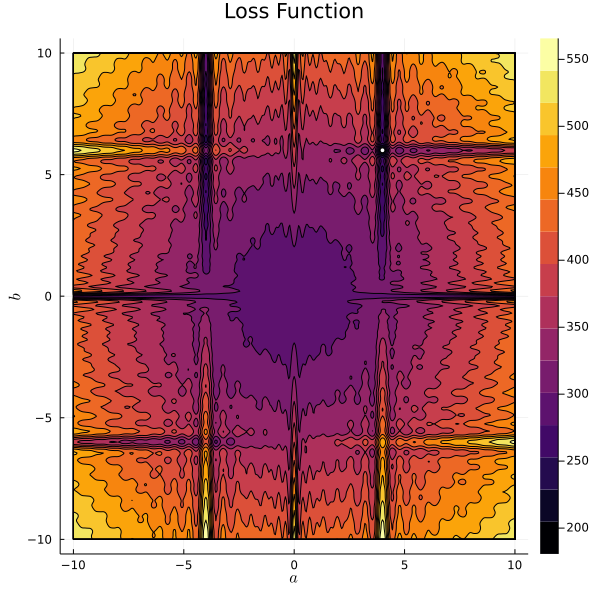

In [6]:
f_params(_a, _b) = [_a*sin(_b*x) + _b*cos(_a*x) for x in x_range]
f_params(p) = f_params(p...)
Loss(p) = norm(y_range - f_params(p))
Loss_plotter(_a, _b) = Loss([_a, _b]);
aa = -10:.05:10
bb = -10:.05:10

contour(aa, bb, Loss_plotter, fill=true, title = "Loss Function")
plot!(xlabel=L"a", ylabel=L"b", size=(600,600), legend=:none)
scatter!([a], [b], color=:white, label = "Known Solution", markersize = 3)

We may then perform Basin Hopping to obtain our solution:

In [7]:
global now = time()
xPlot = []
yPlot = []
solPlotX = []
solPlotY = []
searchX = []
searchY = []
minsX = []
minsY = []
finalSolX = []
finalSolY = []
distNoiseX = []
distNoiseY = []
timings = []
normDif = []

n = 2
rng = 250
minX = -rng
maxX = rng
rand_num_points = 100
x0 = rng*(2*rand(n) .- 1)
ϵ = 1e-8
η = 1e-2
α = 0.5
β = 0.8
κ = 1
ℓ = 0.4
ℓ_range = (0.2, abs(maxX - minX))
γ = 0.9
ϕ = 0.0
T = 1
static_threshold = 10
target_acc_rate = 0.6
maxIterations = 500

runtime = @elapsed minSol = Basin_Hopping(Loss, x0, rand_num_points, minX, maxX, α, 
    β, η, ϵ, κ, ℓ, ℓ_range, γ, ϕ, T, target_acc_rate, maxIterations, static_threshold)

[2.7184619630375995, 69.6186927752348]
Computing first solution
Starting Basin Hopping

Iteration 1
Step Acceptance Rate = 100.0%
Step size = 0.4444444444444445
x = [4.0014287726749425, 5.996185925367858]
Objective = 180.65530522348064
n = 2

Iteration 2
Step Acceptance Rate = 100.0%
Step size = 0.4938271604938272
x = [4.0014288912549185, 5.996186258617648]
Objective = 180.65530522317692
n = 2

Iteration 3
Step Acceptance Rate = 100.0%
Step size = 0.5486968449931413
x = [4.001428821099114, 5.996186742234699]
Objective = 180.65530522306852
n = 2

Iteration 4
Step Acceptance Rate = 100.0%
Step size = 0.6096631611034903
x = [4.001428800669835, 5.996187367862768]
Objective = 180.65530522410717
n = 2

Iteration 5
Step Acceptance Rate = 100.0%
Step size = 0.6774035123372114
x = [4.001428945160634, 5.996185665105459]
Objective = 180.65530522428796
n = 2

Iteration 6
Step Acceptance Rate = 100.0%
Step size = 0.7526705692635682
x = [4.001428594856174, 5.996186005373264]
Objective = 180.65530522

26.0001701

In [8]:
minSol

([4.0014286821771865, 5.996186439057076], 180.65530522313247)

We see that we get very close to our original parameters. Due to the fact that we generated the noisy datapoints randomly, the global minimum of our loss function will not be precisely the solution to our original problem. However, depending on the number of datapoints we have, it should be relatively close.

We may see just how close our solution is by plotting it with our new parameters:

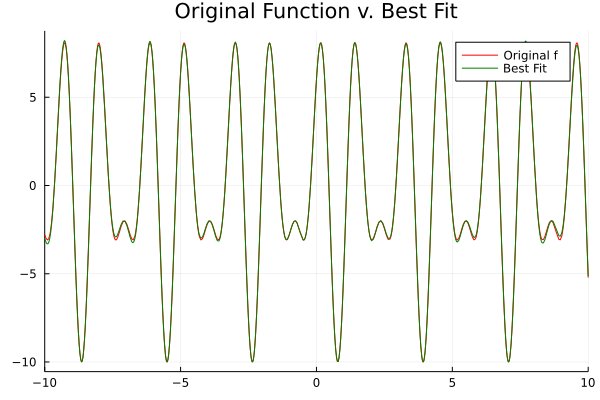

In [9]:
params = minSol[1]
sol(x) = params[1]*sin(params[2]*x) + params[2]*cos(params[1]*x)
plot(f, label = "Original f", title = "Original Function v. Best Fit", xrange = (-10, 10), color =:red, markersize = 2)
plot!(sol, label = "Best Fit", color=:green, markersize = 2)

### Finding Best Fit When We Do Not Know The Problem Structure

When we do not know the problem structure, we may approximate pieces of it with a polynomial and join each resulting polynomial with a cubic spline. This has the added benefit of being extremely parallelizable.

However, how do we pick our polynomial degree? Basin Hopping problems become increasingly more difficult to solve with more parameters but we do not want to lose accuracy either.

Let us test solutions of varying degree.

#### 0th Degree Polynomial Fitting (Step Function)

Firstly, we will attempt to fit the data with a step function.

In [10]:
f_params(_a, _b) = [_a*sin(_b*x) + _b*cos(_a*x) for x in x_range]
f_params(p) = f_params(p...)
Loss(p) = norm(y_range - f_params(p))
Loss_plotter(_a, _b) = Loss([_a, _b]);
aa = -10:.05:10
bb = -10:.05:10

-10.0:0.05:10.0

In [11]:
threads = 64
k = length(x_range)

x_data = [[x_range[n] for n in Int((i-1)*k/threads) + 1:Int(i*k/threads)] for i in 1:threads]
y_data = [[y_range[n] for n in Int((i-1)*k/threads) + 1:Int(i*k/threads)] for i in 1:threads];

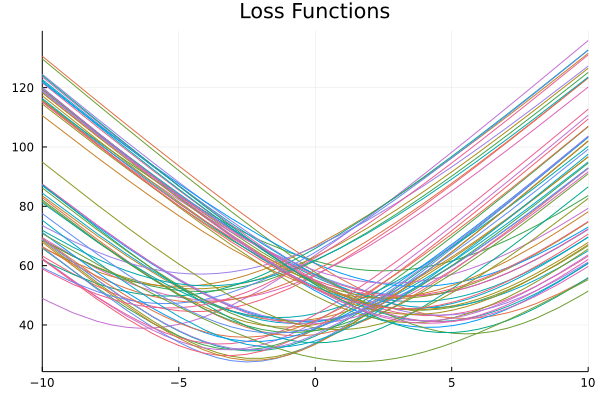

In [12]:
loss_funcs = Array{Function}(undef, threads)
for i = 1:threads
    dat = x_data[i]
    dat_y = y_data[i]
    if i != threads
        dat = vcat(x_data[i], x_data[i+1])
        dat_y = vcat(y_data[i], y_data[i+1])
    end
    loss_funcs[i] = p -> norm(dat_y .- [p[1] for x in dat])
end
plot(loss_funcs, xrange = (-10, 10), legend = false, title = "Loss Functions")

As can be seen, each of our many loss functions can simply be solved using traditional optimization techniques. We do not need Basin Hopping yet. Observe the following solution:

In [13]:
constSols = []
for i = 1:threads
    x = 1.0
    o = optimize(loss_funcs[i], [x])
    push!(constSols, Polynomial(Optim.minimizer(o)))
end

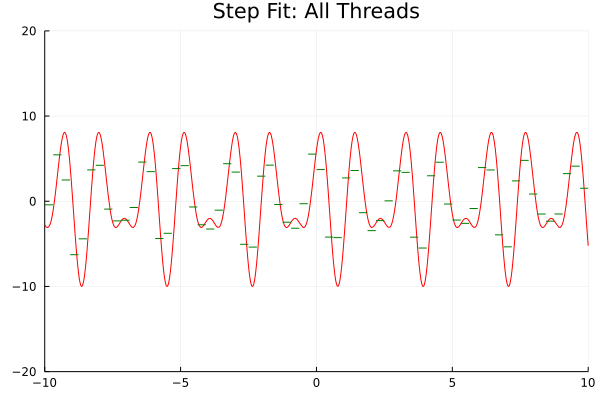

In [14]:
a = 4.0
b = 6.0

f(x) = a*sin(b*x) + b*cos(a*x)

p = plot(f, yrange = (-20, 20), xrange = (-10, 10), color=:red, title = "Step Fit: All Threads")

for i = 1:threads
    plot!(x_data[i], [constSols[i](x) for x ∈ x_data[i]], color=:green, markersize = 2,xrange = (-10, 10), legend = false)
end
p

The previous graph depicts the raw step function. Next, we add a cubic spline to make the result continuous.

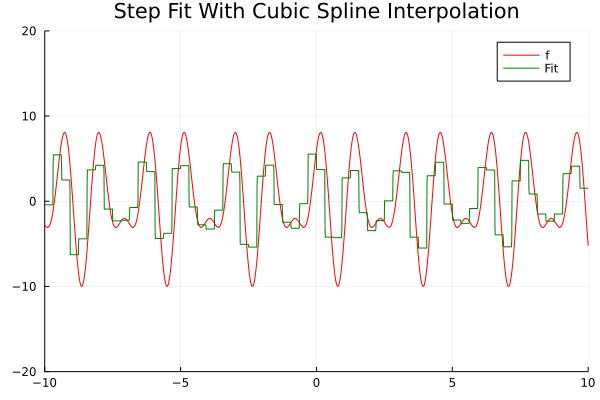

In [15]:
spline_x = Float64[]
spline_y = Float64[]
for i = 1:threads
    spline_x = vcat(spline_x, x_data[i])
    spline_y = vcat(spline_y, [constSols[i](x) for x ∈ x_data[i]])
end

spline = CubicSpline(spline_x, spline_y)
xs = range(-10, 10, length=2000)
ys = spline[xs]

p = plot(f, yrange = (-20, 20), xrange = (-10, 10), color=:red, label = "f", title = "Step Fit With Cubic Spline Interpolation")
plot!(xs, ys, color=:green, label = "Fit")

The result is not very accurate but it does give us a good baseline.

#### 1st Degree Polynomial Fitting (Linear)

Now, we will add a second parameter to our approximation model, turning it into a linear approximation.

In [16]:
loss_funcs = Array{Function}(undef, threads)
for i = 1:threads
    dat = x_data[i]
    dat_y = y_data[i]
    if i != threads
        dat = vcat(x_data[i], x_data[i+1])
        dat_y = vcat(y_data[i], y_data[i+1])
    end
    loss_funcs[i] = p -> norm(dat_y .- [p[2]*x + p[1] for x in dat])
end

loss_funcs[1]([1.0,2.0]) #testing running one of the functions

149.01393135771934

First, we will try a fit using pure Gradient Descent.

In [17]:
polySols = []
xPlot = []
yPlot = []
global now = time()
solPlotX = []
solPlotY = []
searchX = []
searchY = []
minsX = []
minsY = []
finalSolX = []
finalSolY = []
distNoiseX = []
distNoiseY = []
timings = []
normDif = []
for i = 1:threads
    n = 2
    rng = 50
    x0 = rng*(2*rand(n) .- 1)
    η = 1e-4
    α = 0.5
    β = 0.8
    κ = 1
    x, fx = Grad_Descent(loss_funcs[i], x0, α, β, η, κ, 500)
    push!(polySols, Polynomial(x))
end

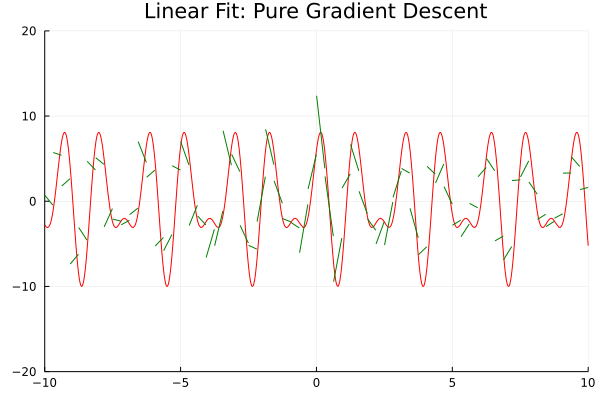

In [18]:
a = 4.0
b = 6.0

f(x) = a*sin(b*x) + b*cos(a*x)

p = plot(f, yrange = (-20, 20), xrange = (-10, 10), color=:red, title = "Linear Fit: Pure Gradient Descent")

for i = 1:threads
    plot!(x_data[i], [polySols[i](x) for x ∈ x_data[i]], color=:green, markersize = 2,xrange = (-10, 10), legend = false)
end
p

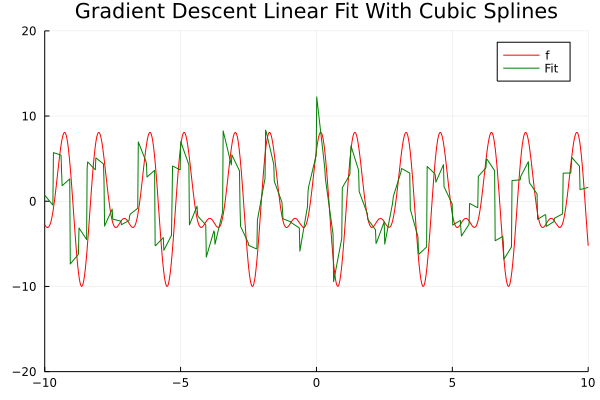

In [19]:
spline_x = Float64[]
spline_y = Float64[]
for i = 1:threads
    spline_x = vcat(spline_x, x_data[i])
    spline_y = vcat(spline_y, [polySols[i](x) for x ∈ x_data[i]])
end

spline = CubicSpline(spline_x, spline_y)
xs = range(-10, 10, length=1000)
ys = spline[xs]

p = plot(f, yrange = (-20, 20), xrange = (-10, 10), color=:red, label = "f", title = "Gradient Descent Linear Fit With Cubic Splines")
plot!(xs, ys, color=:green, label = "Fit")

As can be seen, this fit is not very accurate since pure Gradient Descent fails to find the global minimum of our loss function.

We can improve on this fit significantly by using basin hopping

In [20]:
polySols = []
for i = 1:threads
    print("Thread: ", i)
    global now = time()
    xPlot = []
    yPlot = []
    solPlotX = []
    solPlotY = []
    searchX = []
    searchY = []
    minsX = []
    minsY = []
    finalSolX = []
    finalSolY = []
    distNoiseX = []
    distNoiseY = []
    timings = []
    normDif = []

    n = 2
    rng = 250
    minX = -rng
    maxX = rng
    rand_num_points = 5
    x0 = rng*(2*rand(n) .- 1)
    ϵ = 1e-8
    η = 1e-2
    α = 0.5
    β = 0.8
    κ = 1
    ℓ = 0.4
    ℓ_range = (0.2, abs(maxX - minX))
    γ = 0.9
    ϕ = 0.0
    T = 1
    static_threshold = 3
    target_acc_rate = 0.6
    maxIterations = 15
    
    runtime = @elapsed minSol = Basin_Hopping(loss_funcs[i], x0, rand_num_points, minX, maxX, α, 
        β, η, ϵ, κ, ℓ, ℓ_range, γ, ϕ, T, target_acc_rate, maxIterations, static_threshold)
    push!(polySols, Polynomial(minSol[1]))
end

Thread: 1[248.46311816293797, -74.50761374588267]
Computing first solution
Starting Basin Hopping

Iteration 1
Step Acceptance Rate = 100.0%
Step size = 0.4444444444444445
x = [101.52754242660909, 10.521116181036877]
Objective = 34.49924532719966
n = 2

Iteration 2
Step Acceptance Rate = 100.0%
Step size = 0.4938271604938272
x = [101.93967319652873, 10.563130668431194]
Objective = 34.48338017878399
n = 2

Iteration 3
Step Acceptance Rate = 100.0%
Step size = 0.5486968449931413
x = [102.64627944980913, 10.63608309378309]
Objective = 34.45637347246595
n = 2

Iteration 4
Step Acceptance Rate = 100.0%
Step size = 0.6096631611034903
x = [103.6520189020071, 10.740201757896985]
Objective = 34.41844506435828
n = 2

Iteration 5
Step Acceptance Rate = 100.0%
Step size = 0.6774035123372114
x = [104.5893541556971, 10.834915584658821]
Objective = 34.38401084512655
n = 2

Iteration 6
Step Acceptance Rate = 100.0%
Step size = 0.7526705692635682
x = [104.97473425791173, 10.876970625480192]
Objective =

Step Acceptance Rate = 100.0%
Step size = 1.0324699166852787
x = [-73.80449784819716, -9.713940060698091]
Objective = 36.38915947055581
n = 2

Iteration 10
Step Acceptance Rate = 100.0%
Step size = 1.1471887963169762
x = [-74.24016048222185, -9.774645035128664]
Objective = 36.37355250519133
n = 2

Iteration 11
Step Acceptance Rate = 100.0%
Step size = 1.2746542181299736
x = [-74.39096065169404, -9.79514334709749]
Objective = 36.36827501199327
n = 2

Iteration 12
Step Acceptance Rate = 100.0%
Step size = 1.4162824645888594
x = [-74.98869372623989, -9.873443265905061]
Objective = 36.3472859533742
n = 2

Iteration 13
Step Acceptance Rate = 100.0%
Step size = 1.5736471828765104
x = [-75.81748338400502, -9.985541204340509]
Objective = 36.319060137828956
n = 2

Iteration 14
Step Acceptance Rate = 100.0%
Step size = 1.7484968698627892
x = [-76.28342899192425, -10.046581416998887]
Objective = 36.303269013830594
n = 2

Iteration 15
Step Acceptance Rate = 100.0%
Step size = 1.9427742998475435
x 

Step Acceptance Rate = 100.0%
Step size = 1.1471887963169762
x = [162.84383689181988, 25.302323218878982]
Objective = 35.994518631392516
n = 2

Iteration 11
Step Acceptance Rate = 100.0%
Step size = 1.2746542181299736
x = [161.3819526335402, 25.069551002950895]
Objective = 35.89901729859011
n = 2

Iteration 12
Step Acceptance Rate = 100.0%
Step size = 1.4162824645888594
x = [160.63880204319545, 24.949238968248487]
Objective = 35.851537316610255
n = 2

Iteration 13
Step Acceptance Rate = 100.0%
Step size = 1.5736471828765104
x = [160.04090381157053, 24.85446784078305]
Objective = 35.81390870541215
n = 2

Iteration 14
Step Acceptance Rate = 100.0%
Step size = 1.7484968698627892
x = [158.34348068402974, 24.58233872068072]
Objective = 35.70979863980309
n = 2

Iteration 15
Step Acceptance Rate = 100.0%
Step size = 1.9427742998475435
x = [157.7891408079065, 24.493714779334873]
Objective = 35.67666344747946
n = 2
Thread: 13[-128.55248698412657, 206.84315619275807]
Computing first solution
Sta

Computing first solution
Starting Basin Hopping

Iteration 1
Step Acceptance Rate = 100.0%
Step size = 0.4444444444444445
x = [71.95546624911626, 13.63234962365138]
Objective = 36.32904754509573
n = 2

Iteration 2
Step Acceptance Rate = 100.0%
Step size = 0.4938271604938272
x = [73.40632089570893, 13.91399467758561]
Objective = 36.23773869547426
n = 2

Iteration 3
Step Acceptance Rate = 100.0%
Step size = 0.5486968449931413
x = [74.70616500789833, 14.171627846695111]
Objective = 36.161164378588666
n = 2

Iteration 4
Step Acceptance Rate = 100.0%
Step size = 0.6096631611034903
x = [75.8827926934247, 14.409064350315091]
Objective = 36.094898089953624
n = 2

Iteration 5
Step Acceptance Rate = 100.0%
Step size = 0.6774035123372114
x = [77.17195719945518, 14.660063622780882]
Objective = 36.026682897720185
n = 2

Iteration 6
Step Acceptance Rate = 100.0%
Step size = 0.7526705692635682
x = [78.11591736094495, 14.853978821159215]
Objective = 35.977764388877
n = 2

Iteration 7
Step Acceptance R

Step Acceptance Rate = 100.0%
Step size = 1.7484968698627892
x = [-0.5176841290354882, 0.5514273883295934]
Objective = 31.55744917987322
n = 2

Iteration 15
Step Acceptance Rate = 100.0%
Step size = 1.9427742998475435
x = [-0.5898978401904333, 0.533560917455503]
Objective = 31.556702777742977
n = 2
Thread: 20[-240.19902573871687, 249.3553381479573]
Computing first solution
Starting Basin Hopping

Iteration 1
Step Acceptance Rate = 100.0%
Step size = 0.4444444444444445
x = [-28.29507849502155, -6.658574465271682]
Objective = 33.17909459509318
n = 2

Iteration 2
Step Acceptance Rate = 100.0%
Step size = 0.4938271604938272
x = [-25.70894226571191, -5.9667840737706435]
Objective = 32.89118271368155
n = 2

Iteration 3
Step Acceptance Rate = 100.0%
Step size = 0.5486968449931413
x = [-22.697014641900818, -5.174639526439474]
Objective = 32.59187449917449
n = 2

Iteration 4
Step Acceptance Rate = 100.0%
Step size = 0.6096631611034903
x = [-20.936435274090957, -4.702680664546056]
Objective = 32

x = [-64.06714397778836, -23.980558733569335]
Objective = 36.21884043196293
n = 2

Iteration 8
Step Acceptance Rate = 100.0%
Step size = 0.9292229250167509
x = [-63.959975843638105, -23.94250838624122]
Objective = 36.21791113767891
n = 2
Thread: 24[-89.74619745728785, -120.18868234990354]
Computing first solution
Starting Basin Hopping

Iteration 1
Step Acceptance Rate = 100.0%
Step size = 0.4444444444444445
x = [-72.7996800914908, -27.068567257908086]
Objective = 39.09354419615846
n = 2

Iteration 2
Step Acceptance Rate = 100.0%
Step size = 0.4938271604938272
x = [-71.67648775294138, -26.62926682116847]
Objective = 39.04626270528264
n = 2

Iteration 3
Step Acceptance Rate = 100.0%
Step size = 0.5486968449931413
x = [-70.5839239670059, -26.199116819723606]
Objective = 39.01081094152365
n = 2

Iteration 4
Step Acceptance Rate = 100.0%
Step size = 0.6096631611034903
x = [-69.81116096537563, -25.88442502865985]
Objective = 38.9914621190573
n = 2

Iteration 5
Step Acceptance Rate = 100.0%


Computing first solution
Starting Basin Hopping

Iteration 1
Step Acceptance Rate = 100.0%
Step size = 0.4444444444444445
x = [12.462192904663675, -27.955137499274407]
Objective = 34.22801029541326
n = 2

Iteration 2
Step Acceptance Rate = 100.0%
Step size = 0.4938271604938272
x = [12.489591290572442, -28.042846780395713]
Objective = 34.228012519169454
n = 2

Iteration 3
Step Acceptance Rate = 100.0%
Step size = 0.5486968449931413
x = [12.447175392164, -27.909297178792336]
Objective = 34.22819575282642
n = 2
Thread: 34[-68.23199966927207, -116.2578052539892]
Computing first solution
Starting Basin Hopping

Iteration 1
Step Acceptance Rate = 100.0%
Step size = 0.4444444444444445
x = [10.450773542242732, -23.442434721003565]
Objective = 33.721973807636324
n = 2

Iteration 2
Step Acceptance Rate = 100.0%
Step size = 0.4938271604938272
x = [10.32129446168689, -23.246161246504958]
Objective = 33.721510838739505
n = 2

Iteration 3
Step Acceptance Rate = 100.0%
Step size = 0.5486968449931413


Step Acceptance Rate = 100.0%
Step size = 1.1471887963169762
x = [-51.58486393532165, 17.639799201643235]
Objective = 35.632953541466506
n = 2

Iteration 11
Step Acceptance Rate = 100.0%
Step size = 1.2746542181299736
x = [-49.85840861819818, 17.086286245337554]
Objective = 35.528464911699636
n = 2

Iteration 12
Step Acceptance Rate = 100.0%
Step size = 1.4162824645888594
x = [-48.34686350269608, 16.590370360637333]
Objective = 35.45171005385524
n = 2

Iteration 13
Step Acceptance Rate = 100.0%
Step size = 1.5736471828765104
x = [-46.813258812445575, 16.10401255035303]
Objective = 35.38761018470378
n = 2

Iteration 14
Step Acceptance Rate = 100.0%
Step size = 1.7484968698627892
x = [-45.33457538841468, 15.632062633504097]
Objective = 35.33936189428611
n = 2

Iteration 15
Step Acceptance Rate = 100.0%
Step size = 1.9427742998475435
x = [-43.96956827457044, 15.205419129333873]
Objective = 35.30637508807121
n = 2
Thread: 43[123.74727131717533, 29.789594502141135]
Computing first solution


Computing first solution
Starting Basin Hopping

Iteration 1
Step Acceptance Rate = 100.0%
Step size = 0.4444444444444445
x = [-66.98156031424756, 16.005431500993083]
Objective = 34.703764998562114
n = 2

Iteration 2
Step Acceptance Rate = 100.0%
Step size = 0.4938271604938272
x = [-68.85957171356709, 16.44499359884115]
Objective = 34.43062642323707
n = 2

Iteration 3
Step Acceptance Rate = 100.0%
Step size = 0.5486968449931413
x = [-71.05684661599614, 16.937436435733456]
Objective = 34.116988431373045
n = 2

Iteration 4
Step Acceptance Rate = 100.0%
Step size = 0.6096631611034903
x = [-73.00527169786231, 17.373559839251907]
Objective = 33.851787559437305
n = 2

Iteration 5
Step Acceptance Rate = 100.0%
Step size = 0.6774035123372114
x = [-74.65976117119713, 17.75877681454398]
Objective = 33.634167390236634
n = 2

Iteration 6
Step Acceptance Rate = 100.0%
Step size = 0.7526705692635682
x = [-75.85657150452603, 18.031300476257737]
Objective = 33.48153345261772
n = 2

Iteration 7
Step Ac

Step Acceptance Rate = 100.0%
Step size = 0.9292229250167509
x = [-3.394046550099267, 0.2242440701320988]
Objective = 34.38317493554157
n = 2

Iteration 9
Step Acceptance Rate = 100.0%
Step size = 1.0324699166852787
x = [-3.525858501180602, 0.24948711629691317]
Objective = 34.381299163887384
n = 2

Iteration 10
Step Acceptance Rate = 100.0%
Step size = 1.1471887963169762
x = [-4.333563967042008, 0.4013764035833039]
Objective = 34.370658348183994
n = 2

Iteration 11
Step Acceptance Rate = 100.0%
Step size = 1.2746542181299736
x = [-4.4231093990673624, 0.4175733350473629]
Objective = 34.369573052288935
n = 2

Iteration 12
Step Acceptance Rate = 100.0%
Step size = 1.4162824645888594
x = [-4.532546880278499, 0.438207992100927]
Objective = 34.36825773070147
n = 2

Iteration 13
Step Acceptance Rate = 100.0%
Step size = 1.5736471828765104
x = [-5.3002994540567725, 0.5829625305366535]
Objective = 34.35975812160543
n = 2

Iteration 14
Step Acceptance Rate = 100.0%
Step size = 1.7484968698627892

Step Acceptance Rate = 100.0%
Step size = 1.7484968698627892
x = [-140.1258099695122, 23.031144525349866]
Objective = 35.492212061126565
n = 2

Iteration 15
Step Acceptance Rate = 100.0%
Step size = 1.9427742998475435
x = [-138.91106580580058, 22.840676001472875]
Objective = 35.41496180337105
n = 2
Thread: 53[240.97454500772875, -90.3551514995633]
Computing first solution
Starting Basin Hopping

Iteration 1
Step Acceptance Rate = 100.0%
Step size = 0.4444444444444445
x = [87.39696071226275, -12.759769040034195]
Objective = 37.883543737313786
n = 2

Iteration 2
Step Acceptance Rate = 100.0%
Step size = 0.4938271604938272
x = [87.49750017059614, -12.771907572461236]
Objective = 37.87894586908028
n = 2

Iteration 3
Step Acceptance Rate = 100.0%
Step size = 0.5486968449931413
x = [88.0290545281569, -12.852085325357054]
Objective = 37.85725940642125
n = 2

Iteration 4
Step Acceptance Rate = 100.0%
Step size = 0.6096631611034903
x = [88.44408217425608, -12.915107554091305]
Objective = 37.840

n = 2

Iteration 14
Step Acceptance Rate = 100.0%
Step size = 1.7484968698627892
x = [69.41370036348025, -8.26870965762911]
Objective = 33.36393222497769
n = 2
Thread: 58[208.1623947736525, -157.34133985463495]
Computing first solution
Starting Basin Hopping

Iteration 1
Step Acceptance Rate = 100.0%
Step size = 0.4444444444444445
x = [223.503826093115, -27.380673643805533]
Objective = 35.997199603192676
n = 2

Iteration 2
Step Acceptance Rate = 100.0%
Step size = 0.4938271604938272
x = [223.09903565513946, -27.33478736629785]
Objective = 35.961548493205726
n = 2

Iteration 3
Step Acceptance Rate = 100.0%
Step size = 0.5486968449931413
x = [222.5991035914701, -27.274170078916107]
Objective = 35.918708869008796
n = 2

Iteration 4
Step Acceptance Rate = 100.0%
Step size = 0.6096631611034903
x = [222.1276133103635, -27.215085674265914]
Objective = 35.87833310506501
n = 2

Iteration 5
Step Acceptance Rate = 100.0%
Step size = 0.6774035123372114
x = [221.8227560319048, -27.178178235114938]


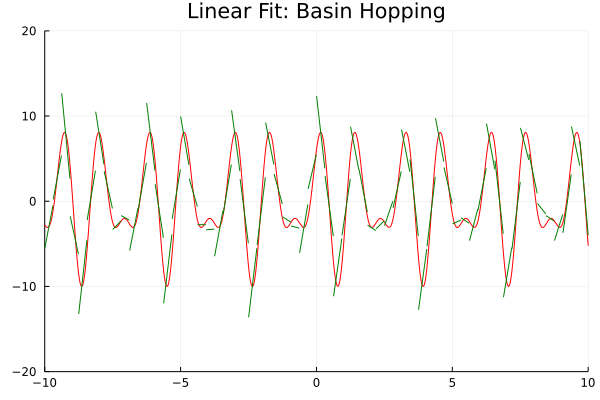

In [21]:
a = 4.0
b = 6.0

f(x) = a*sin(b*x) + b*cos(a*x)

p = plot(f, yrange = (-20, 20), xrange = (-10, 10), color=:red, title = "Linear Fit: Basin Hopping")

for i = 1:threads
    plot!(x_data[i], [polySols[i](x) for x ∈ x_data[i]], color=:green, markersize = 2,xrange = (-10, 10), legend = false)
end
p

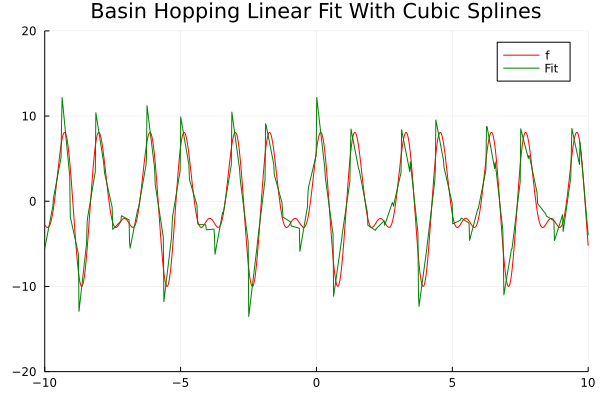

In [22]:
spline_x = Float64[]
spline_y = Float64[]
for i = 1:threads
    spline_x = vcat(spline_x, x_data[i])
    spline_y = vcat(spline_y, [polySols[i](x) for x ∈ x_data[i]])
end

spline = CubicSpline(spline_x, spline_y)
xs = range(-10, 10, length=1000)
ys = spline[xs]

p = plot(f, yrange = (-20, 20), xrange = (-10, 10), color=:red, label = "f", title = "Basin Hopping Linear Fit With Cubic Splines")
plot!(xs, ys, color=:green, label = "Fit")

We observe a much better fit after using Basin Hopping.

#### 2nd Degree Polynomial Fitting

We will now try to fit our data with a quadratic.

In [23]:
loss_funcs = Array{Function}(undef, threads)
for i = 1:threads
    dat = x_data[i]
    dat_y = y_data[i]
    if i != threads
        dat = vcat(x_data[i], x_data[i+1])
        dat_y = vcat(y_data[i], y_data[i+1])
    end
    loss_funcs[i] = p -> norm(dat_y .- [p[3]*x^2 + p[2]*x + p[1] for x in dat])
end

loss_funcs[1]([1.0,2.0, 3.0]) #testing running one of the functions

2114.5283458115455

In [24]:
polySols = []
for i = 1:threads
    global now = time()
    xPlot = []
    yPlot = []
    solPlotX = []
    solPlotY = []
    searchX = []
    searchY = []
    minsX = []
    minsY = []
    finalSolX = []
    finalSolY = []
    distNoiseX = []
    distNoiseY = []
    timings = []
    normDif = []

    n = 3
    rng = 200.0
    minX = -rng
    maxX = rng
    rand_num_points = 5
    x0 = rng*(2*rand(n) .- 1)
    ϵ = 1e-8
    η = 1e-2
    α = 0.5
    β = 0.8
    κ = 1
    ℓ = 0.4
    ℓ_range = (0.2, abs(maxX - minX))
    γ = 0.9
    ϕ = 0.0
    T = 1
    static_threshold = 5
    target_acc_rate = 0.6
    maxIterations = 50
    
    runtime = @elapsed minSol = Basin_Hopping(loss_funcs[i], x0, rand_num_points, minX, maxX, α, 
        β, η, ϵ, κ, ℓ, ℓ_range, γ, ϕ, T, target_acc_rate, maxIterations, static_threshold)
    push!(polySols, Polynomial(minSol[1]))
end

[192.0069112085594, 68.56956522082012, 172.90125450277012]
Computing first solution
Starting Basin Hopping

Iteration 1
Step Acceptance Rate = 100.0%
Step size = 0.4444444444444445
x = [191.03122159090537, 81.7956536562683, 6.394833004100792]
Objective = 91.2080044012848
n = 3

Iteration 2
Step Acceptance Rate = 100.0%
Step size = 0.4938271604938272
x = [191.02405954591185, 81.39940756310035, 6.353798956246679]
Objective = 90.67838681791424
n = 3

Iteration 3
Step Acceptance Rate = 100.0%
Step size = 0.5486968449931413
x = [191.13442527183207, 81.28383472645577, 6.341138211492742]
Objective = 90.49275171951189
n = 3

Iteration 4
Step Acceptance Rate = 100.0%
Step size = 0.6096631611034903
x = [191.2273572122253, 81.03275889546747, 6.313906379401863]
Objective = 90.13040778703527
n = 3

Iteration 5
Step Acceptance Rate = 100.0%
Step size = 0.6774035123372114
x = [191.24667902504524, 80.63841367527294, 6.273163901972385]
Objective = 89.59675812344618
n = 3

Iteration 6
Step Acceptance Ra

Step Acceptance Rate = 100.0%
Step size = 0.4938271604938272
x = [194.70591218356262, 93.80741498938416, 8.003248600053901]
Objective = 42.79110177270909
n = 3

Iteration 3
Step Acceptance Rate = 100.0%
Step size = 0.5486968449931413
x = [194.56953756075188, 93.51467154128717, 7.972555734669824]
Objective = 42.55761611760966
n = 3

Iteration 4
Step Acceptance Rate = 100.0%
Step size = 0.6096631611034903
x = [194.69181210865935, 93.5979729654357, 7.9804066255160215]
Objective = 42.60744475772219
n = 3

Iteration 5
Step Acceptance Rate = 100.0%
Step size = 0.6774035123372114
x = [194.74641178166246, 93.26182244747422, 7.942742521623773]
Objective = 42.30052610850982
n = 3

Iteration 6
Step Acceptance Rate = 100.0%
Step size = 0.7526705692635682
x = [194.80338940542399, 93.43136111095376, 7.960562407700084]
Objective = 42.43856531741896
n = 3

Iteration 7
Step Acceptance Rate = 100.0%
Step size = 0.8363006325150758
x = [194.56710509886662, 93.48692888556182, 7.970150444984024]
Objective =

x = [-24.20118147482718, -25.694942438906033, -2.7655985738961295]
Objective = 33.887184312363416
n = 3

Iteration 12
Step Acceptance Rate = 100.0%
Step size = 1.4162824645888594
x = [-23.633951827369273, -25.325289713251333, -2.7299251107605382]
Objective = 33.996167038415166
n = 3

Iteration 13
Step Acceptance Rate = 100.0%
Step size = 1.5736471828765104
x = [-23.548975880624774, -25.016677584839766, -2.6945795651086626]
Objective = 34.134723041818134
n = 3

Iteration 14
Step Acceptance Rate = 100.0%
Step size = 1.7484968698627892
x = [-24.138724140718104, -25.331517966228837, -2.7228699141008237]
Objective = 34.05313113635007
n = 3

Iteration 15
Step Acceptance Rate = 100.0%
Step size = 1.9427742998475435
x = [-23.854076618878242, -26.10965636167002, -2.8196814042550438]
Objective = 33.66501979279288
n = 3

Iteration 16
Step Acceptance Rate = 100.0%
Step size = 2.1586381109417148
x = [-22.986449658766, -26.694666731289324, -2.9010299662941543]
Objective = 33.339920715805874
n = 3

I

Step Acceptance Rate = 87.87878787878788%
Step size = 12.943662483361159
x = [150.66140390627154, 13.727597086645329, -0.5350309657027824]
Objective = 39.23783103372094
n = 3

Iteration 34
Step Acceptance Rate = 88.23529411764706%
Step size = 14.38184720373462
x = [151.40514401249425, 18.00012344977724, -0.021316840087468966]
Objective = 39.032112440301745
n = 3

Iteration 35
Step Acceptance Rate = 88.57142857142857%
Step size = 15.979830226371801
x = [151.2003389256888, 19.731815396147212, 0.1945391912982815]
Objective = 39.21919250377664
n = 3

Iteration 36
Step Acceptance Rate = 86.11111111111111%
Step size = 17.75536691819089
x = [151.2003389256888, 19.731815396147212, 0.1945391912982815]
Objective = 39.210170102919044
n = 3

Iteration 37
Step Acceptance Rate = 86.48648648648648%
Step size = 19.728185464656544
x = [145.2536846476506, 13.799356488239939, -0.4445993265360546]
Objective = 39.055726239127246
n = 3

Iteration 38
Step Acceptance Rate = 84.21052631578947%
Step size = 21.9

Step Acceptance Rate = 71.7948717948718%
Step size = 24.355784524267335
x = [-27.227733007240964, 35.31121645956283, 5.026879078810853]
Objective = 45.68541331704619
n = 3

Iteration 40
Step Acceptance Rate = 72.5%
Step size = 27.061982804741483
x = [-20.973180009931543, 30.05555212645286, 4.2533951407467185]
Objective = 39.12883642612111
n = 3

Iteration 41
Step Acceptance Rate = 73.17073170731707%
Step size = 30.06886978304609
x = [-12.676642705597102, 22.33581238220838, 3.1316596757850412]
Objective = 32.77377374847283
n = 3

Iteration 42
Step Acceptance Rate = 71.42857142857143%
Step size = 33.40985531449565
x = [-12.676642705597102, 22.33581238220838, 3.1316596757850412]
Objective = 32.48053088375778
n = 3

Iteration 43
Step Acceptance Rate = 72.09302325581395%
Step size = 37.122061460550725
x = [-0.8952672563040762, 17.650544354889135, 2.340858763331278]
Objective = 31.581528856127207
n = 3

Iteration 44
Step Acceptance Rate = 72.72727272727273%
Step size = 41.24673495616747
x = 

x = [80.64334710729808, 21.389832226385998, 1.4037207907547533]
Objective = 41.56815823445993
n = 3

Iteration 35
Step Acceptance Rate = 77.14285714285715%
Step size = 15.979830226371801
x = [79.18965722349682, 20.845488604324284, 1.3570869506837964]
Objective = 41.6859175566064
n = 3

Iteration 36
Step Acceptance Rate = 77.77777777777779%
Step size = 17.75536691819089
x = [78.82256903015728, 20.294927874706183, 1.289961973090606]
Objective = 42.02835957232303
n = 3

Iteration 37
Step Acceptance Rate = 75.67567567567568%
Step size = 19.728185464656544
x = [78.82256903015728, 20.294927874706183, 1.289961973090606]
Objective = 41.41954681870594
n = 3

Iteration 38
Step Acceptance Rate = 76.31578947368422%
Step size = 21.920206071840603
x = [74.90720917406605, 28.312229063878497, 2.425731359730062]
Objective = 36.80442678542033
n = 3

Iteration 39
Step Acceptance Rate = 74.35897435897436%
Step size = 24.355784524267335
x = [74.90720917406605, 28.312229063878497, 2.425731359730062]
Objecti

Step Acceptance Rate = 100.0%
Step size = 1.0324699166852787
x = [-42.02563792679988, -60.05597380490286, -7.874469904583219]
Objective = 77.9320441478135
n = 3

Iteration 10
Step Acceptance Rate = 100.0%
Step size = 1.1471887963169762
x = [-42.88067162057251, -58.04849966953543, -7.56533289039937]
Objective = 74.9184715687575
n = 3

Iteration 11
Step Acceptance Rate = 100.0%
Step size = 1.2746542181299736
x = [-44.275816773867355, -55.262970558973684, -7.131520343129424]
Objective = 70.69166182817666
n = 3

Iteration 12
Step Acceptance Rate = 100.0%
Step size = 1.4162824645888594
x = [-44.671641784543276, -54.8487735248088, -7.062624157576756]
Objective = 69.99558451191854
n = 3

Iteration 13
Step Acceptance Rate = 100.0%
Step size = 1.5736471828765104
x = [-45.09654825233514, -54.565644468824374, -7.013025517339438]
Objective = 69.46096387574353
n = 3

Iteration 14
Step Acceptance Rate = 100.0%
Step size = 1.7484968698627892
x = [-44.530960001925884, -54.1754203361027, -6.96929488547

Step Acceptance Rate = 90.9090909090909%
Step size = 1.2746542181299736
x = [35.54216278724556, 7.017284542166167, 0.22412132628377923]
Objective = 37.390555463580775
n = 3

Iteration 12
Step Acceptance Rate = 91.66666666666666%
Step size = 1.4162824645888594
x = [35.04749891412628, 6.543034365923634, 0.16338437330946204]
Objective = 37.17324159647246
n = 3

Iteration 13
Step Acceptance Rate = 92.3076923076923%
Step size = 1.5736471828765104
x = [35.68545296581308, 6.56961438311369, 0.1532583809316432]
Objective = 37.06148263381335
n = 3

Iteration 14
Step Acceptance Rate = 85.71428571428571%
Step size = 1.7484968698627892
x = [35.68545296581308, 6.56961438311369, 0.1532583809316432]
Objective = 36.98613658853474
n = 3

Iteration 15
Step Acceptance Rate = 86.66666666666667%
Step size = 1.9427742998475435
x = [35.4486835815191, 6.705215264956008, 0.17948054753605955]
Objective = 37.19979447212442
n = 3

Iteration 16
Step Acceptance Rate = 87.5%
Step size = 2.1586381109417148
x = [34.799

x = [-48.484469840950446, -36.31213525541276, -4.445725271897772]
Objective = 34.04793140853745
n = 3

Iteration 38
Step Acceptance Rate = 76.31578947368422%
Step size = 21.920206071840603
x = [-52.08617283409391, -36.11680279045477, -4.322801151257119]
Objective = 34.0212704668253
n = 3

Iteration 39
Step Acceptance Rate = 76.92307692307693%
Step size = 24.355784524267335
x = [-59.11925710006366, -32.427027410222045, -3.555455608451483]
Objective = 35.224540277186485
n = 3

Iteration 40
Step Acceptance Rate = 75.0%
Step size = 27.061982804741483
x = [-59.11925710006366, -32.427027410222045, -3.555455608451483]
Objective = 35.180680815488714
n = 3

Iteration 41
Step Acceptance Rate = 73.17073170731707%
Step size = 30.06886978304609
x = [-59.11925710006366, -32.427027410222045, -3.555455608451483]
Objective = 35.180680815488714
n = 3

Iteration 42
Step Acceptance Rate = 73.80952380952381%
Step size = 33.40985531449565
x = [-58.309884870716054, -37.453202977997165, -4.377711564056772]
Ob

Step Acceptance Rate = 100.0%
Step size = 0.7526705692635682
x = [-19.137127361305318, 14.476627283197928, 3.0357029558777873]
Objective = 32.57820168831458
n = 3

Iteration 7
Step Acceptance Rate = 100.0%
Step size = 0.8363006325150758
x = [-18.986523439680486, 14.617839794446335, 3.0559877474544788]
Objective = 32.56999520321288
n = 3

Iteration 8
Step Acceptance Rate = 100.0%
Step size = 0.9292229250167509
x = [-19.419387219860667, 14.585210313609535, 3.063805336286939]
Objective = 32.56203595450829
n = 3

Iteration 9
Step Acceptance Rate = 100.0%
Step size = 1.0324699166852787
x = [-19.358401556475155, 14.908258251650377, 3.119424749366313]
Objective = 32.54179470638875
n = 3

Iteration 10
Step Acceptance Rate = 100.0%
Step size = 1.1471887963169762
x = [-18.90360026816485, 14.595152156314132, 3.049276193582534]
Objective = 32.574131758675506
n = 3

Iteration 11
Step Acceptance Rate = 100.0%
Step size = 1.2746542181299736
x = [-18.626614169128658, 14.416229386403929, 3.008310741390

Step Acceptance Rate = 76.47058823529412%
Step size = 2.3984867899352387
x = [101.37286236422622, 27.745959005896722, 1.643799534892967]
Objective = 37.27589766476716
n = 3

Iteration 18
Step Acceptance Rate = 77.77777777777779%
Step size = 2.6649853221502653
x = [101.01402941801878, 27.257710932529847, 1.5597345966984644]
Objective = 37.23045072361276
n = 3

Iteration 19
Step Acceptance Rate = 78.94736842105263%
Step size = 2.9610948023891837
x = [101.389242799544, 26.73652891609594, 1.4397782820462697]
Objective = 36.94808534238398
n = 3

Iteration 20
Step Acceptance Rate = 80.0%
Step size = 3.290105335987982
x = [101.43880644844984, 26.704906825465333, 1.4321128596488577]
Objective = 36.926942848410036
n = 3

Iteration 21
Step Acceptance Rate = 80.95238095238095%
Step size = 3.6556725955422023
x = [100.47265821641629, 26.923991186613854, 1.5147715532009394]
Objective = 37.176908466674654
n = 3

Iteration 22
Step Acceptance Rate = 77.27272727272727%
Step size = 4.061858439491336
x = 

x = [92.63879541373473, 57.68982821670208, 8.292470808496]
Objective = 32.686958708866136
n = 3
[71.7508258114008, -72.94808694210033, 112.5529694024089]
Computing first solution
Starting Basin Hopping

Iteration 1
Step Acceptance Rate = 100.0%
Step size = 0.4444444444444445
x = [-49.143142320174114, 25.959768277230822, 9.130125419615974]
Objective = 76.61391886631031
n = 3

Iteration 2
Step Acceptance Rate = 50.0%
Step size = 0.4
x = [-49.143142320174114, 25.959768277230822, 9.130125419615974]
Objective = 65.45427706874284
n = 3

Iteration 3
Step Acceptance Rate = 33.33333333333333%
Step size = 0.36000000000000004
x = [-49.143142320174114, 25.959768277230822, 9.130125419615974]
Objective = 65.45427706874284
n = 3

Iteration 4
Step Acceptance Rate = 25.0%
Step size = 0.32400000000000007
x = [-49.143142320174114, 25.959768277230822, 9.130125419615974]
Objective = 65.45427706874284
n = 3

Iteration 5
Step Acceptance Rate = 40.0%
Step size = 0.2916000000000001
x = [-45.29914623166806, 18.

x = [-7.981084567745142, 12.799075516852458, 3.7208034488299253]
Objective = 38.70088312716883
n = 3

Iteration 6
Step Acceptance Rate = 83.33333333333334%
Step size = 0.6096631611034903
x = [-7.188745258002195, 11.69269273143943, 3.3595226318526326]
Objective = 37.500304478178904
n = 3

Iteration 7
Step Acceptance Rate = 71.42857142857143%
Step size = 0.6774035123372114
x = [-7.188745258002195, 11.69269273143943, 3.3595226318526326]
Objective = 36.42704523960725
n = 3

Iteration 8
Step Acceptance Rate = 75.0%
Step size = 0.7526705692635682
x = [-6.523417030101716, 10.85339069458137, 3.1013569310938784]
Objective = 36.58969432365717
n = 3

Iteration 9
Step Acceptance Rate = 77.77777777777779%
Step size = 0.8363006325150758
x = [-5.810341170453056, 9.42890608552655, 2.6616472217572444]
Objective = 35.38857105627368
n = 3

Iteration 10
Step Acceptance Rate = 70.0%
Step size = 0.9292229250167509
x = [-5.810341170453056, 9.42890608552655, 2.6616472217572444]
Objective = 32.96814471663345
n

Step Acceptance Rate = 100.0%
Step size = 0.5486968449931413
x = [175.25315023357754, 149.59639129208406, 31.319553734747764]
Objective = 39.96035495711787
n = 3

Iteration 4
Step Acceptance Rate = 100.0%
Step size = 0.6096631611034903
x = [175.69547705292877, 149.12886223525908, 31.105702170599663]
Objective = 39.8199645618293
n = 3

Iteration 5
Step Acceptance Rate = 100.0%
Step size = 0.6774035123372114
x = [175.87056623703856, 148.5374060848472, 30.875101974991054]
Objective = 39.71486230000341
n = 3

Iteration 6
Step Acceptance Rate = 100.0%
Step size = 0.7526705692635682
x = [176.13600757823775, 148.21183994979648, 30.726784964632238]
Objective = 39.657680985741635
n = 3

Iteration 7
Step Acceptance Rate = 100.0%
Step size = 0.8363006325150758
x = [176.25641721457424, 147.5594315208671, 30.483837487413258]
Objective = 39.59502964167931
n = 3

Iteration 8
Step Acceptance Rate = 100.0%
Step size = 0.9292229250167509
x = [176.37286374087543, 147.59248289225152, 30.477475935422163]
O

[138.4353483763494, -21.16386012891338, 53.64859799387727]
Computing first solution
Starting Basin Hopping

Iteration 1
Step Acceptance Rate = 100.0%
Step size = 0.4444444444444445
x = [-83.29951421170976, -121.55166985353303, -39.902061114522]
Objective = 28.684166118098325
n = 3

Iteration 2
Step Acceptance Rate = 100.0%
Step size = 0.4938271604938272
x = [-84.38888203872614, -121.1397967593286, -39.39303646338373]
Objective = 28.565099467629693
n = 3

Iteration 3
Step Acceptance Rate = 100.0%
Step size = 0.5486968449931413
x = [-84.56018263267947, -121.04863159752924, -39.29817194034111]
Objective = 28.56190955589606
n = 3

Iteration 4
Step Acceptance Rate = 100.0%
Step size = 0.6096631611034903
x = [-84.66148379952007, -121.04872606996702, -39.27207282207409]
Objective = 28.56184552413776
n = 3

Iteration 5
Step Acceptance Rate = 100.0%
Step size = 0.6774035123372114
x = [-84.78706718885512, -121.18258268609212, -39.30477493858502]
Objective = 28.560935157098577
n = 3

Iteration 6


Step Acceptance Rate = 100.0%
Step size = 4.513176043879262
x = [9.676849452136237, 45.64083975145855, 37.06021659914497]
Objective = 29.073450285236817
n = 3

Iteration 24
Step Acceptance Rate = 100.0%
Step size = 5.014640048754735
x = [9.966192045328462, 46.62582731047086, 37.841309496563156]
Objective = 29.089581461312974
n = 3

Iteration 25
Step Acceptance Rate = 100.0%
Step size = 5.57182227639415
x = [9.503933606855115, 45.05734809955102, 36.59612178955334]
Objective = 29.06444076873182
n = 3
[83.58659707227912, -9.130811648032822, 195.3090401674805]
Computing first solution
Starting Basin Hopping

Iteration 1
Step Acceptance Rate = 100.0%
Step size = 0.4444444444444445
x = [8.35754484448829, 44.2629457411554, 40.079079422018566]
Objective = 31.124712854648052
n = 3

Iteration 2
Step Acceptance Rate = 100.0%
Step size = 0.4938271604938272
x = [8.095210731271825, 41.86747317748455, 36.32010206854454]
Objective = 30.89025234259718
n = 3

Iteration 3
Step Acceptance Rate = 100.0%
St

Step Acceptance Rate = 100.0%
Step size = 2.3984867899352387
x = [6.208803625900281, 13.298209851827252, -20.492740811165138]
Objective = 31.08217014735081
n = 3
[188.26889255329408, 35.14280272539274, -99.60129906236955]
Computing first solution
Starting Basin Hopping

Iteration 1
Step Acceptance Rate = 100.0%
Step size = 0.4444444444444445
x = [8.244418140214067, 12.78630236812019, -65.41484291328617]
Objective = 29.51433322932498
n = 3

Iteration 2
Step Acceptance Rate = 100.0%
Step size = 0.4938271604938272
x = [8.181119144922349, 13.372122455143538, -66.33380077026659]
Objective = 29.49879314236874
n = 3

Iteration 3
Step Acceptance Rate = 100.0%
Step size = 0.5486968449931413
x = [8.122754843358193, 13.996664882352245, -67.30766592381791]
Objective = 29.484000291361056
n = 3

Iteration 4
Step Acceptance Rate = 100.0%
Step size = 0.6096631611034903
x = [8.06295961203779, 14.534005572547231, -68.15143406070297]
Objective = 29.472608419407717
n = 3

Iteration 5
Step Acceptance Rate 

Step Acceptance Rate = 97.05882352941177%
Step size = 14.38184720373462
x = [26.723802243595166, -80.92818244178905, 46.44320285466835]
Objective = 29.328580664058542
n = 3

Iteration 35
Step Acceptance Rate = 97.14285714285714%
Step size = 15.979830226371801
x = [25.838396506313334, -77.87933697728373, 44.03471669010411]
Objective = 29.476563807378874
n = 3

Iteration 36
Step Acceptance Rate = 97.22222222222221%
Step size = 17.75536691819089
x = [25.16237934133216, -75.5389235640133, 42.18617617938322]
Objective = 29.59700103708081
n = 3

Iteration 37
Step Acceptance Rate = 97.2972972972973%
Step size = 19.728185464656544
x = [25.971022491926956, -78.3132798525046, 44.37999860385372]
Objective = 29.45498647658692
n = 3

Iteration 38
Step Acceptance Rate = 97.36842105263158%
Step size = 21.920206071840603
x = [26.564676835502077, -80.38269448355338, 46.01063589939013]
Objective = 29.354335679337233
n = 3
[128.20204200224782, 3.034957014423778, -23.878812711491104]
Computing first solut

n = 3

Iteration 4
Step Acceptance Rate = 100.0%
Step size = 0.6096631611034903
x = [-80.53776839544538, 113.81947068613604, -36.983581793720234]
Objective = 40.782421859490114
n = 3

Iteration 5
Step Acceptance Rate = 100.0%
Step size = 0.6774035123372114
x = [-80.90569912979474, 114.40492679806574, -37.21772977923854]
Objective = 40.76762829804897
n = 3

Iteration 6
Step Acceptance Rate = 100.0%
Step size = 0.7526705692635682
x = [-81.12011282796713, 114.76176460790529, -37.36279796499759]
Objective = 40.75876134162245
n = 3

Iteration 7
Step Acceptance Rate = 100.0%
Step size = 0.8363006325150758
x = [-81.43541080809435, 115.27541775029192, -37.56121690930476]
Objective = 40.74611061133981
n = 3

Iteration 8
Step Acceptance Rate = 100.0%
Step size = 0.9292229250167509
x = [-81.86830870435648, 115.96455459457171, -37.83660211118181]
Objective = 40.72890155594651
n = 3

Iteration 9
Step Acceptance Rate = 100.0%
Step size = 1.0324699166852787
x = [-82.37023489945923, 116.79200637809971

Computing first solution
Starting Basin Hopping

Iteration 1
Step Acceptance Rate = 100.0%
Step size = 0.4444444444444445
x = [74.08020775971379, -64.367315387044, 13.461125746251376]
Objective = 27.775834366117905
n = 3

Iteration 2
Step Acceptance Rate = 100.0%
Step size = 0.4938271604938272
x = [73.96045071391886, -64.456397284327, 13.515010803411744]
Objective = 27.775791139532124
n = 3

Iteration 3
Step Acceptance Rate = 100.0%
Step size = 0.5486968449931413
x = [74.1284996405077, -64.59705163735144, 13.543823834134233]
Objective = 27.776350287155086
n = 3

Iteration 4
Step Acceptance Rate = 100.0%
Step size = 0.6096631611034903
x = [74.21625790814923, -64.66127646007017, 13.55541583707066]
Objective = 27.776573000391615
n = 3

Iteration 5
Step Acceptance Rate = 100.0%
Step size = 0.6774035123372114
x = [74.1715932493346, -64.6300446523047, 13.549510857598506]
Objective = 27.776467483058077
n = 3
[-135.89254979851296, -35.426523623299744, 81.77187208519908]
Computing first solutio

Step Acceptance Rate = 100.0%
Step size = 0.6096631611034903
x = [-72.1929591982451, 68.87764891904844, -13.495106095149275]
Objective = 39.232867230507495
n = 3

Iteration 5
Step Acceptance Rate = 100.0%
Step size = 0.6774035123372114
x = [-72.48354191637468, 68.57920892296251, -13.394799644441072]
Objective = 39.16348036754087
n = 3

Iteration 6
Step Acceptance Rate = 100.0%
Step size = 0.7526705692635682
x = [-72.27924276955746, 68.31201144637345, -13.338082641617811]
Objective = 39.13970562113341
n = 3

Iteration 7
Step Acceptance Rate = 100.0%
Step size = 0.8363006325150758
x = [-72.60861650918197, 68.02249786114469, -13.239230110826085]
Objective = 39.083714369518134
n = 3

Iteration 8
Step Acceptance Rate = 100.0%
Step size = 0.9292229250167509
x = [-72.805680562974, 68.11141198724465, -13.248280547443306]
Objective = 39.08325208874948
n = 3

Iteration 9
Step Acceptance Rate = 100.0%
Step size = 1.0324699166852787
x = [-73.17454547228284, 67.86768129579474, -13.157873955099301]


Step Acceptance Rate = 50.0%
Step size = 0.32400000000000007
x = [-117.55616427378244, 109.12479282693448, -17.664817389040945]
Objective = 65.71929753660397
n = 3

Iteration 3
Step Acceptance Rate = 66.66666666666666%
Step size = 0.36000000000000004
x = [-119.62934327938291, 104.40818743827421, -16.567902206845336]
Objective = 58.843874354638324
n = 3

Iteration 4
Step Acceptance Rate = 75.0%
Step size = 0.4
x = [-120.17381675728015, 103.35356947977509, -16.320259918046794]
Objective = 57.306280812330904
n = 3

Iteration 5
Step Acceptance Rate = 80.0%
Step size = 0.4444444444444445
x = [-120.58878383455338, 102.31218036930572, -16.08111470031474]
Objective = 55.86847337841623
n = 3

Iteration 6
Step Acceptance Rate = 83.33333333333334%
Step size = 0.4938271604938272
x = [-121.30531383971937, 101.0875057914684, -15.790027983294566]
Objective = 54.08869615858547
n = 3

Iteration 7
Step Acceptance Rate = 85.71428571428571%
Step size = 0.5486968449931413
x = [-123.2438186923647, 96.658310

x = [-187.4149018380834, 68.52643513135867, -6.219222661310282]
Objective = 43.91165088399643
n = 3

Iteration 9
Step Acceptance Rate = 100.0%
Step size = 1.0324699166852787
x = [-185.8127508410205, 72.41866190392562, -7.065186552825227]
Objective = 39.91088744225487
n = 3

Iteration 10
Step Acceptance Rate = 100.0%
Step size = 1.1471887963169762
x = [-185.3865842800717, 73.25483962693828, -7.247416128663888]
Objective = 39.11615902944831
n = 3

Iteration 11
Step Acceptance Rate = 100.0%
Step size = 1.2746542181299736
x = [-185.13716607601296, 73.52391094503592, -7.311027529963523]
Objective = 38.834656779505586
n = 3

Iteration 12
Step Acceptance Rate = 100.0%
Step size = 1.4162824645888594
x = [-184.97220641998075, 74.20315921017327, -7.455683179238743]
Objective = 38.28886772938507
n = 3

Iteration 13
Step Acceptance Rate = 100.0%
Step size = 1.5736471828765104
x = [-184.46788731811725, 75.19508258989241, -7.668767467248262]
Objective = 37.44560504066474
n = 3

Iteration 14
Step Acc

Step Acceptance Rate = 95.23809523809523%
Step size = 3.6556725955422023
x = [-196.07177595609787, 82.86713071090243, -8.713877343587923]
Objective = 38.45606645130292
n = 3

Iteration 22
Step Acceptance Rate = 95.45454545454545%
Step size = 4.061858439491336
x = [-195.84958480021652, 82.54656912544249, -8.660605459301]
Objective = 38.31041817261098
n = 3

Iteration 23
Step Acceptance Rate = 91.30434782608695%
Step size = 4.513176043879262
x = [-195.84958480021652, 82.54656912544249, -8.660605459301]
Objective = 38.12293118317197
n = 3

Iteration 24
Step Acceptance Rate = 91.66666666666666%
Step size = 5.014640048754735
x = [-195.32815363795248, 83.55923685305002, -8.87022464984116]
Objective = 39.07702126056392
n = 3

Iteration 25
Step Acceptance Rate = 92.0%
Step size = 5.57182227639415
x = [-197.60462094911202, 82.20445881625297, -8.534171498608508]
Objective = 37.72687304358531
n = 3

Iteration 26
Step Acceptance Rate = 88.46153846153845%
Step size = 6.190913640437945
x = [-197.604

Step Acceptance Rate = 86.20689655172413%
Step size = 8.492336955333258
x = [91.49771231185572, -25.836231640854677, 1.6195587982142186]
Objective = 36.66900918904241
n = 3

Iteration 30
Step Acceptance Rate = 86.66666666666667%
Step size = 9.435929950370285
x = [87.91272448348012, -24.826102938642492, 1.5533491790317948]
Objective = 36.58493178282822
n = 3

Iteration 31
Step Acceptance Rate = 87.09677419354838%
Step size = 10.484366611522539
x = [85.01232560475206, -24.74824593004356, 1.6308316639775515]
Objective = 36.330667108115726
n = 3

Iteration 32
Step Acceptance Rate = 87.5%
Step size = 11.649296235025043
x = [88.25401054550588, -27.78751714508948, 2.0679472693813303]
Objective = 35.99207998924161
n = 3

Iteration 33
Step Acceptance Rate = 87.87878787878788%
Step size = 12.943662483361159
x = [93.7850579751195, -28.107365469409064, 1.9500149916991882]
Objective = 36.29090588437377
n = 3

Iteration 34
Step Acceptance Rate = 88.23529411764706%
Step size = 14.38184720373462
x = [

Step Acceptance Rate = 100.0%
Step size = 1.1471887963169762
x = [-91.80103683002443, 12.924816162172942, 0.3812996958349531]
Objective = 34.19293369094364
n = 3
[-145.70567333883142, 57.99287319929434, -5.029563720011421]
Computing first solution
Starting Basin Hopping

Iteration 1
Step Acceptance Rate = 100.0%
Step size = 0.4444444444444445
x = [-145.61205333531154, 57.92792215492392, -5.356947039876079]
Objective = 37.45194092376936
n = 3

Iteration 2
Step Acceptance Rate = 100.0%
Step size = 0.4938271604938272
x = [-145.37493056090818, 57.79913918427868, -5.342952523895579]
Objective = 37.46984908831997
n = 3

Iteration 3
Step Acceptance Rate = 100.0%
Step size = 0.5486968449931413
x = [-145.5113923532622, 57.82915925220015, -5.344419278590492]
Objective = 37.47313186463437
n = 3

Iteration 4
Step Acceptance Rate = 100.0%
Step size = 0.6096631611034903
x = [-145.25161707692538, 57.91478837092394, -5.363348141106551]
Objective = 37.423280536408214
n = 3

Iteration 5
Step Acceptance 

Step Acceptance Rate = 71.7948717948718%
Step size = 14.38184720373462
x = [36.05644379134449, -22.70685485552925, 2.444555909368361]
Objective = 66.06366408769465
n = 3

Iteration 40
Step Acceptance Rate = 72.5%
Step size = 15.979830226371801
x = [34.381261003488504, -14.323117384895623, 1.2610269943914731]
Objective = 56.67961683296447
n = 3

Iteration 41
Step Acceptance Rate = 73.17073170731707%
Step size = 17.75536691819089
x = [40.75646852598859, -14.119753488491446, 1.0992347117281702]
Objective = 54.32875844281243
n = 3

Iteration 42
Step Acceptance Rate = 73.80952380952381%
Step size = 19.728185464656544
x = [44.191023135376525, -6.681414819973598, -0.0532776933995945]
Objective = 45.57009529471559
n = 3

Iteration 43
Step Acceptance Rate = 74.4186046511628%
Step size = 21.920206071840603
x = [52.02910585661438, 2.424877306732474, -1.5365174924609886]
Objective = 36.89578277532326
n = 3

Iteration 44
Step Acceptance Rate = 75.0%
Step size = 24.355784524267335
x = [55.2854543564

Step Acceptance Rate = 100.0%
Step size = 0.4938271604938272
x = [188.796964357325, -49.67901372448644, 3.262803689556499]
Objective = 41.397280699203165
n = 3

Iteration 3
Step Acceptance Rate = 100.0%
Step size = 0.5486968449931413
x = [188.93649036572089, -49.79638420189838, 3.2751840829341496]
Objective = 41.4749916497579
n = 3

Iteration 4
Step Acceptance Rate = 100.0%
Step size = 0.6096631611034903
x = [189.1822192677059, -49.85737802773693, 3.278877814587709]
Objective = 41.475680586621166
n = 3

Iteration 5
Step Acceptance Rate = 100.0%
Step size = 0.6774035123372114
x = [189.50196033164443, -49.861685111348244, 3.275002944159688]
Objective = 41.40510066893209
n = 3

Iteration 6
Step Acceptance Rate = 100.0%
Step size = 0.7526705692635682
x = [189.24752818997854, -49.87821908569316, 3.280883815622755]
Objective = 41.479447661272275
n = 3

Iteration 7
Step Acceptance Rate = 100.0%
Step size = 0.8363006325150758
x = [188.92713931397452, -49.56180463762344, 3.2469456381941257]
Obj

[-148.99590419319165, 175.3908437971373, -155.69025064082993]
Computing first solution
Starting Basin Hopping

Iteration 1
Step Acceptance Rate = 100.0%
Step size = 0.4444444444444445
x = [-24.2314942826079, 68.72132722167937, -7.558465764750661]
Objective = 94.20984281716818
n = 3

Iteration 2
Step Acceptance Rate = 100.0%
Step size = 0.4938271604938272
x = [-24.073502339336542, 68.34781096652256, -7.514350457627706]
Objective = 93.73057666374358
n = 3

Iteration 3
Step Acceptance Rate = 100.0%
Step size = 0.5486968449931413
x = [-24.260001546925874, 68.14764179050927, -7.488773792720693]
Objective = 93.40150460594224
n = 3

Iteration 4
Step Acceptance Rate = 75.0%
Step size = 0.6096631611034903
x = [-24.260001546925874, 68.14764179050927, -7.488773792720693]
Objective = 93.12201407866684
n = 3

Iteration 5
Step Acceptance Rate = 80.0%
Step size = 0.6774035123372114
x = [-24.419958918573144, 68.13928991237553, -7.485739182040919]
Objective = 93.34053879176561
n = 3

Iteration 6
Step A

Step Acceptance Rate = 80.0%
Step size = 45.82970550685275
x = [-46.831882925712364, 13.812723277616076, -0.9967195058276723]
Objective = 31.523017053232344
n = 3

Iteration 46
Step Acceptance Rate = 78.26086956521739%
Step size = 50.92189500761416
x = [-46.831882925712364, 13.812723277616076, -0.9967195058276723]
Objective = 31.523017053232344
n = 3

Iteration 47
Step Acceptance Rate = 78.72340425531915%
Step size = 56.57988334179351
x = [-37.99977467155856, 14.580115667876978, -1.1984548193134879]
Objective = 32.06099675367593
n = 3

Iteration 48
Step Acceptance Rate = 77.08333333333334%
Step size = 62.86653704643723
x = [-37.99977467155856, 14.580115667876978, -1.1984548193134879]
Objective = 31.965438233495895
n = 3
[-147.49712011946653, -27.550008776537815, -67.73726075495273]
Computing first solution
Starting Basin Hopping

Iteration 1
Step Acceptance Rate = 100.0%
Step size = 0.4444444444444445
x = [-33.462931538193416, -3.5384907588236674, 0.7787558937566236]
Objective = 34.197

Step size = 1.2746542181299736
x = [119.87020356818132, -52.34723669511278, 4.16437599398141]
Objective = 71.78782356827544
n = 3

Iteration 12
Step Acceptance Rate = 91.66666666666666%
Step size = 1.4162824645888594
x = [119.82298511476526, -51.8749075163152, 4.11574653583574]
Objective = 71.20151304939714
n = 3

Iteration 13
Step Acceptance Rate = 92.3076923076923%
Step size = 1.5736471828765104
x = [119.20239179714268, -52.39237882031127, 4.177437213099247]
Objective = 72.02865545268885
n = 3

Iteration 14
Step Acceptance Rate = 92.85714285714286%
Step size = 1.7484968698627892
x = [119.80490138706905, -51.63837428757824, 4.091839913969189]
Objective = 70.90674593966845
n = 3

Iteration 15
Step Acceptance Rate = 93.33333333333333%
Step size = 1.9427742998475435
x = [120.61567789121413, -51.66713207838898, 4.086074212269725]
Objective = 70.7321149150226
n = 3

Iteration 16
Step Acceptance Rate = 93.75%
Step size = 2.1586381109417148
x = [120.13073210927436, -50.6617686989403, 3.98786

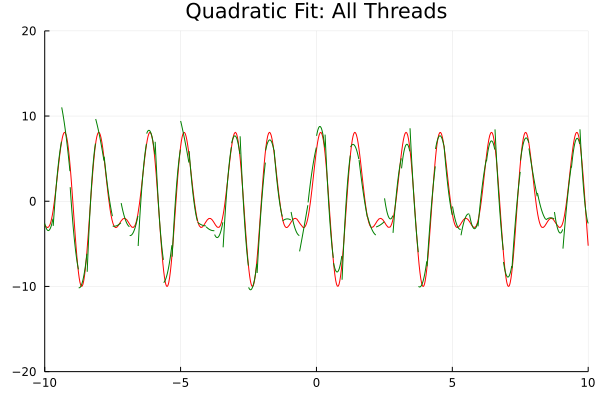

In [25]:
a = 4.0
b = 6.0

f(x) = a*sin(b*x) + b*cos(a*x)

p = plot(f, yrange = (-20, 20), xrange = (-10, 10), color=:red, title = "Quadratic Fit: All Threads")

for i = 1:threads
    plot!(x_data[i], [polySols[i](x) for x ∈ x_data[i]], color=:green, markersize = 2,xrange = (-10, 10), legend = false)
end
p

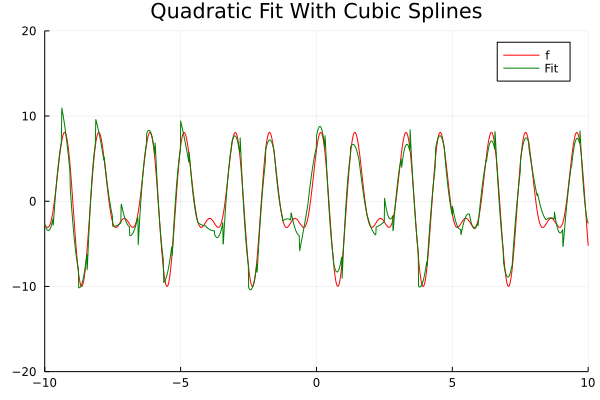

In [26]:
spline_x = Float64[]
spline_y = Float64[]
for i = 1:threads
    spline_x = vcat(spline_x, x_data[i])
    spline_y = vcat(spline_y, [polySols[i](x) for x ∈ x_data[i]])
end

spline = CubicSpline(spline_x, spline_y)
xs = range(-10, 10, length=2000)
ys = spline[xs]

p = plot(f, yrange = (-20, 20), xrange = (-10, 10), color=:red, label = "f", title = "Quadratic Fit With Cubic Splines")
plot!(xs, ys, color=:green, label = "Fit")

We observe a good fit. However, adding the third parameter caused this computation to take significantly longer than the linear fit.

### Solving More Difficult Fits

Performing the piecewise fit as we have been doing has other benefits as well. Suppose our function $f:\mathbb{R}\to\mathbb{R}$ had many more parameters than $2$. Even if we knew the strucure of $f$, it might not be practical to solve it by fitting the parameters exactly. 

However, by using the piecewise fit technique, we may produce good results in reasonable time. As an example, consider the following generalization of our function from before:

$$
\sum_{i=1}^n \left(a_i\sin(b_i x) + b_i\cos(a_i x)\right)
$$

Here, using the piecewise fit method has a significant advantage in that the number of parameters here is essentially irrelevent.

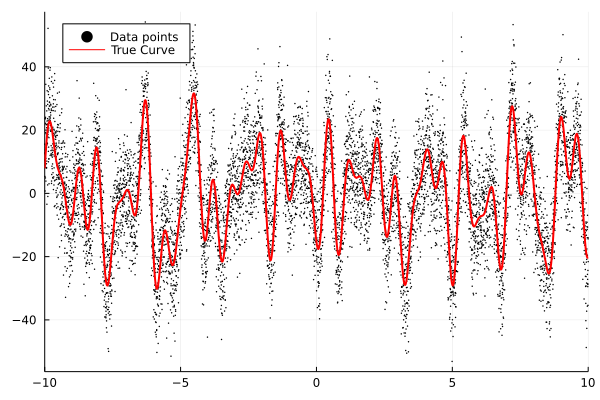

In [124]:
n = 10
a = 5*randn(n)
b = 5*randn(n)
fff(x) = sum(a[i]*sin(b[i]*x) + b[i]*cos(a[i]*x) for i ∈ 1:n)

#Generate noisy data
datasize = 8192
variation = 10
x_range = range(-10, 10, length=datasize)
y_range = fff.(x_range) + randn(datasize)*variation

scatter(x_range, y_range, label = "Data points", color=:black, markersize = 1)
plot!(fff, legend=:topleft, label = "True Curve", color=:red, xrange = (-10, 10), linewidth = 2)

In [125]:
threads = 128
k = length(x_range)

x_data = [[x_range[n] for n in Int((i-1)*k/threads) + 1:Int(i*k/threads)] for i in 1:threads]
y_data = [[y_range[n] for n in Int((i-1)*k/threads) + 1:Int(i*k/threads)] for i in 1:threads];

loss_funcs = Array{Function}(undef, threads)
for i = 1:threads
    dat = x_data[i]
    dat_y = y_data[i]
    if i != threads
        dat = vcat(x_data[i], x_data[i+1])
        dat_y = vcat(y_data[i], y_data[i+1])
    end
    loss_funcs[i] = p -> norm(dat_y .- [p[2]*x + p[1] for x in dat])
end

loss_funcs[1]([1.0,2.0])

441.9644576369995

In [ ]:
polySols = []
for i = 1:threads
    print("Thread: ", i)
    global now = time()
    xPlot = []
    yPlot = []
    solPlotX = []
    solPlotY = []
    searchX = []
    searchY = []
    minsX = []
    minsY = []
    finalSolX = []
    finalSolY = []
    distNoiseX = []
    distNoiseY = []
    timings = []
    normDif = []

    n = 2
    rng = 1000
    minX = -rng
    maxX = rng
    rand_num_points = 25
    x0 = rng*(2*rand(n) .- 1)
    ϵ = 1e-8
    η = 1e-2
    α = 0.5
    β = 0.8
    κ = 1
    ℓ = 0.4
    ℓ_range = (0.2, abs(maxX - minX))
    γ = 0.9
    ϕ = 0.0
    T = 1
    static_threshold = 10
    target_acc_rate = 0.6
    maxIterations = 15
    
    runtime = @elapsed minSol = Basin_Hopping(loss_funcs[i], x0, rand_num_points, minX, maxX, α, 
        β, η, ϵ, κ, ℓ, ℓ_range, γ, ϕ, T, target_acc_rate, maxIterations, static_threshold)
    push!(polySols, Polynomial(minSol[1]))
end

Thread: 1[448.3695009819169, -364.3762812613356]
Computing first solution
Starting Basin Hopping

Iteration 1
Step Acceptance Rate = 100.0%
Step size = 0.4444444444444445
x = [158.7478930639798, 14.183701951841298]
Objective = 111.11930726308017
n = 2

Iteration 2
Step Acceptance Rate = 100.0%
Step size = 0.4938271604938272
x = [158.8350894486631, 14.192564977612665]
Objective = 111.11945868164514
n = 2

Iteration 3
Step Acceptance Rate = 100.0%
Step size = 0.5486968449931413
x = [159.04495968953512, 14.213870978866982]
Objective = 111.11982612425376
n = 2

Iteration 4
Step Acceptance Rate = 100.0%
Step size = 0.6096631611034903
x = [159.03963675221704, 14.21332579321412]
Objective = 111.11981675328501
n = 2

Iteration 5
Step Acceptance Rate = 100.0%
Step size = 0.6774035123372114
x = [158.835570375895, 14.192607234164749]
Objective = 111.11945951417563
n = 2

Iteration 6
Step Acceptance Rate = 100.0%
Step size = 0.7526705692635682
x = [159.15060788795958, 14.22461639920711]
Objective 

Computing first solution
Starting Basin Hopping

Iteration 1
Step Acceptance Rate = 100.0%
Step size = 0.4444444444444445
x = [-24.08366391572978, -1.9126778721539746]
Objective = 113.64077287429043
n = 2

Iteration 2
Step Acceptance Rate = 100.0%
Step size = 0.4938271604938272
x = [-23.909749415421597, -1.893485344997854]
Objective = 113.64072202684187
n = 2

Iteration 3
Step Acceptance Rate = 100.0%
Step size = 0.5486968449931413
x = [-23.67127259898564, -1.8671642231282772]
Objective = 113.64065779811196
n = 2

Iteration 4
Step Acceptance Rate = 100.0%
Step size = 0.6096631611034903
x = [-23.769649462311797, -1.8780164331925782]
Objective = 113.64068352584663
n = 2

Iteration 5
Step Acceptance Rate = 100.0%
Step size = 0.6774035123372114
x = [-23.928662396299877, -1.8955691529423577]
Objective = 113.64072739141243
n = 2

Iteration 6
Step Acceptance Rate = 100.0%
Step size = 0.7526705692635682
x = [-23.722137731461306, -1.8727853231951532]
Objective = 113.64067096331407
n = 2

Iterat

Computing first solution
Starting Basin Hopping

Iteration 1
Step Acceptance Rate = 100.0%
Step size = 0.4444444444444445
x = [664.7901438442739, 80.50363021106497]
Objective = 116.22246926139795
n = 2

Iteration 2
Step Acceptance Rate = 100.0%
Step size = 0.4938271604938272
x = [664.5567306581495, 80.47546188268278]
Objective = 116.22282822206105
n = 2

Iteration 3
Step Acceptance Rate = 100.0%
Step size = 0.5486968449931413
x = [664.6340902945309, 80.48479152644227]
Objective = 116.2227084602079
n = 2

Iteration 4
Step Acceptance Rate = 100.0%
Step size = 0.6096631611034903
x = [664.398089188162, 80.45628389705122]
Objective = 116.22307625288421
n = 2

Iteration 5
Step Acceptance Rate = 100.0%
Step size = 0.6774035123372114
x = [664.2819395883134, 80.4422886522426]
Objective = 116.22325993349878
n = 2

Iteration 6
Step Acceptance Rate = 100.0%
Step size = 0.7526705692635682
x = [664.1442585891206, 80.42563017673665]
Objective = 116.22347996024912
n = 2

Iteration 7
Step Acceptance Ra

x = [127.80507861996082, 19.94435237581312]
Objective = 113.9007130823651
n = 2

Iteration 7
Step Acceptance Rate = 100.0%
Step size = 0.8363006325150758
x = [127.83671936808202, 19.949176457103107]
Objective = 113.90051720762679
n = 2

Iteration 8
Step Acceptance Rate = 100.0%
Step size = 0.9292229250167509
x = [127.70092827595087, 19.931592000328965]
Objective = 113.90140582052985
n = 2

Iteration 9
Step Acceptance Rate = 100.0%
Step size = 1.0324699166852787
x = [127.6369805614094, 19.92224639166008]
Objective = 113.90180905548873
n = 2

Iteration 10
Step Acceptance Rate = 100.0%
Step size = 1.1471887963169762
x = [127.84396618457723, 19.949694071258236]
Objective = 113.9004605775686
n = 2
Thread: 16[-866.0818933764949, 818.8535857967394]
Computing first solution
Starting Basin Hopping

Iteration 1
Step Acceptance Rate = 100.0%
Step size = 0.4444444444444445
x = [637.4918309112155, 87.09317543799968]
Objective = 105.55882853920515
n = 2

Iteration 2
Step Acceptance Rate = 100.0%
Ste

x = [-221.56590765401887, -31.920900354855352]
Objective = 116.53339653713688
n = 2

Iteration 7
Step Acceptance Rate = 100.0%
Step size = 0.8363006325150758
x = [-221.470327946917, -31.907439125106627]
Objective = 116.53302030337167
n = 2

Iteration 8
Step Acceptance Rate = 100.0%
Step size = 0.9292229250167509
x = [-221.26755070106117, -31.877930458696977]
Objective = 116.5322355855937
n = 2

Iteration 9
Step Acceptance Rate = 100.0%
Step size = 1.0324699166852787
x = [-221.02719190108087, -31.84301086210107]
Objective = 116.53131563850772
n = 2

Iteration 10
Step Acceptance Rate = 100.0%
Step size = 1.1471887963169762
x = [-220.50177105113224, -31.766821738990437]
Objective = 116.52934438790271
n = 2
Thread: 21[800.1416225371902, -86.15086701197639]
Computing first solution
Starting Basin Hopping

Iteration 1
Step Acceptance Rate = 100.0%
Step size = 0.4444444444444445
x = [-32.3220615504272, -4.132204217280775]
Objective = 118.30466242532832
n = 2

Iteration 2
Step Acceptance Rate 

Step Acceptance Rate = 100.0%
Step size = 1.4162824645888594
x = [-559.7193342082613, -93.17200286826164]
Objective = 123.07137383308972
n = 2

Iteration 13
Step Acceptance Rate = 100.0%
Step size = 1.5736471828765104
x = [-559.4419064653866, -93.1278953836053]
Objective = 123.06397998549384
n = 2

Iteration 14
Step Acceptance Rate = 100.0%
Step size = 1.7484968698627892
x = [-558.9560931308907, -93.05192964341192]
Objective = 123.05123451738582
n = 2

Iteration 15
Step Acceptance Rate = 100.0%
Step size = 1.9427742998475435
x = [-559.0800475862422, -93.06510162641516]
Objective = 123.05444347731118
n = 2
Thread: 25[547.3040338797439, -267.07712320195844]
Computing first solution
Starting Basin Hopping

Iteration 1
Step Acceptance Rate = 100.0%
Step size = 0.4444444444444445
x = [-973.9133933874363, -159.96287807404093]
Objective = 105.13521692491112
n = 2

Iteration 2
Step Acceptance Rate = 100.0%
Step size = 0.4938271604938272
x = [-974.6186562006136, -160.07731182683995]
Objective =

Step Acceptance Rate = 100.0%
Step size = 0.4938271604938272
x = [136.68751071535013, 26.69406383001803]
Objective = 119.00623223188997
n = 2

Iteration 3
Step Acceptance Rate = 100.0%
Step size = 0.5486968449931413
x = [136.96386262911653, 26.743705962058115]
Objective = 119.00284370285287
n = 2

Iteration 4
Step Acceptance Rate = 100.0%
Step size = 0.6096631611034903
x = [137.2762761190131, 26.798742167640388]
Objective = 118.99903990611342
n = 2

Iteration 5
Step Acceptance Rate = 100.0%
Step size = 0.6774035123372114
x = [137.202080304015, 26.785962209893395]
Objective = 118.99994001842018
n = 2

Iteration 6
Step Acceptance Rate = 100.0%
Step size = 0.7526705692635682
x = [137.49503616334587, 26.8386508739123]
Objective = 118.99640067579458
n = 2

Iteration 7
Step Acceptance Rate = 100.0%
Step size = 0.8363006325150758
x = [137.56811654746832, 26.85105573596372]
Objective = 118.99550971868342
n = 2

Iteration 8
Step Acceptance Rate = 100.0%
Step size = 0.9292229250167509
x = [137.8

Step Acceptance Rate = 100.0%
Step size = 0.7526705692635682
x = [259.6491851435122, 52.937304300041895]
Objective = 115.09179614813951
n = 2

Iteration 7
Step Acceptance Rate = 100.0%
Step size = 0.8363006325150758
x = [259.5357478984789, 52.914620891801874]
Objective = 115.09229862637626
n = 2

Iteration 8
Step Acceptance Rate = 100.0%
Step size = 0.9292229250167509
x = [259.70397861238, 52.9487702881985]
Objective = 115.09155729126026
n = 2

Iteration 9
Step Acceptance Rate = 100.0%
Step size = 1.0324699166852787
x = [259.2983206974051, 52.86686813293991]
Objective = 115.0933673910226
n = 2

Iteration 10
Step Acceptance Rate = 100.0%
Step size = 1.1471887963169762
x = [259.7018758543535, 52.94754867394217]
Objective = 115.09156633450182
n = 2
Thread: 33[-660.9596670994597, -4.142166447344664]
Computing first solution
Starting Basin Hopping

Iteration 1
Step Acceptance Rate = 100.0%
Step size = 0.4444444444444445
x = [284.3322041824915, 57.60316349996564]
Objective = 114.225540871717

Iteration 7
Step Acceptance Rate = 71.42857142857143%
Step size = 0.8363006325150758
x = [-512.1854864130155, -120.9786011248021]
Objective = 112.59534102336961
n = 2

Iteration 8
Step Acceptance Rate = 75.0%
Step size = 0.9292229250167509
x = [-513.224517136697, -121.21658451866551]
Objective = 112.6116413600635
n = 2

Iteration 9
Step Acceptance Rate = 77.77777777777779%
Step size = 1.0324699166852787
x = [-514.1079668363178, -121.41846107042824]
Objective = 112.57986312324337
n = 2

Iteration 10
Step Acceptance Rate = 80.0%
Step size = 1.1471887963169762
x = [-514.8911792877769, -121.59318482062059]
Objective = 112.55215935108896
n = 2

Iteration 11
Step Acceptance Rate = 81.81818181818183%
Step size = 1.2746542181299736
x = [-516.1817388581803, -121.89155269119205]
Objective = 112.50671450777791
n = 2

Iteration 12
Step Acceptance Rate = 83.33333333333334%
Step size = 1.4162824645888594
x = [-516.9968625587536, -122.07509519257076]
Objective = 112.47861509544957
n = 2

Iteration 13

Step Acceptance Rate = 100.0%
Step size = 1.5736471828765104
x = [336.5055542339951, 86.42394716071837]
Objective = 119.10256133285323
n = 2

Iteration 14
Step Acceptance Rate = 100.0%
Step size = 1.7484968698627892
x = [335.3897880862956, 86.14144526963774]
Objective = 119.07253562136353
n = 2

Iteration 15
Step Acceptance Rate = 100.0%
Step size = 1.9427742998475435
x = [334.8950888263205, 86.0152039619061]
Objective = 119.05947805009205
n = 2
Thread: 40[342.465759432542, 172.05942037872424]
Computing first solution
Starting Basin Hopping

Iteration 1
Step Acceptance Rate = 100.0%
Step size = 0.4444444444444445
x = [-248.79374786558344, -66.1151454137146]
Objective = 125.33340683501153
n = 2

Iteration 2
Step Acceptance Rate = 100.0%
Step size = 0.4938271604938272
x = [-249.02005435678137, -66.17545112227728]
Objective = 125.33404184958559
n = 2

Iteration 3
Step Acceptance Rate = 100.0%
Step size = 0.5486968449931413
x = [-248.84322481702154, -66.12861552260044]
Objective = 125.3335

Step Acceptance Rate = 100.0%
Step size = 1.1471887963169762
x = [167.19323948835054, 53.418978966818834]
Objective = 109.88922261394411
n = 2

Iteration 11
Step Acceptance Rate = 100.0%
Step size = 1.2746542181299736
x = [168.50395303052096, 53.81811994764184]
Objective = 109.8318232992463
n = 2

Iteration 12
Step Acceptance Rate = 100.0%
Step size = 1.4162824645888594
x = [170.48245241248173, 54.419914203445444]
Objective = 109.74800477418009
n = 2

Iteration 13
Step Acceptance Rate = 100.0%
Step size = 1.5736471828765104
x = [172.09701361423583, 54.91369118166033]
Objective = 109.68207406077222
n = 2

Iteration 14
Step Acceptance Rate = 100.0%
Step size = 1.7484968698627892
x = [173.90939178538542, 55.46425502393262]
Objective = 109.61079778401565
n = 2

Iteration 15
Step Acceptance Rate = 100.0%
Step size = 1.9427742998475435
x = [175.6086142086185, 55.987923736528096]
Objective = 109.54670262167363
n = 2
Thread: 44[-482.72009737351686, 358.4458476973222]
Computing first solution
S

Computing first solution
Starting Basin Hopping

Iteration 1
Step Acceptance Rate = 0.0%
Step size = 0.36000000000000004
x = [65.92469987985592, 21.52680570771799]
Objective = 123.33013900960006
n = 2

Iteration 2
Step Acceptance Rate = 50.0%
Step size = 0.32400000000000007
x = [67.55029256819567, 22.130418800535573]
Objective = 123.33106857143027
n = 2

Iteration 3
Step Acceptance Rate = 66.66666666666666%
Step size = 0.36000000000000004
x = [69.10799180113504, 22.714183073897424]
Objective = 123.2554677872631
n = 2

Iteration 4
Step Acceptance Rate = 75.0%
Step size = 0.4
x = [70.4766287145375, 23.23097784023743]
Objective = 123.19140625645444
n = 2

Iteration 5
Step Acceptance Rate = 80.0%
Step size = 0.4444444444444445
x = [71.860362234983, 23.740086636147645]
Objective = 123.12923010293322
n = 2

Iteration 6
Step Acceptance Rate = 83.33333333333334%
Step size = 0.4938271604938272
x = [73.3507875226957, 24.305342251747945]
Objective = 123.06415012367425
n = 2

Iteration 7
Step Acce

x = [84.45247434863943, 32.32041565087058]
Objective = 114.88369252944977
n = 2

Iteration 7
Step Acceptance Rate = 100.0%
Step size = 0.8363006325150758
x = [83.53258349420507, 31.904285832662374]
Objective = 114.85769457753294
n = 2

Iteration 8
Step Acceptance Rate = 100.0%
Step size = 0.9292229250167509
x = [82.54957589151806, 31.459447875201796]
Objective = 114.83174857563293
n = 2

Iteration 9
Step Acceptance Rate = 100.0%
Step size = 1.0324699166852787
x = [81.48151361459509, 30.9709994951125]
Objective = 114.80549441219611
n = 2

Iteration 10
Step Acceptance Rate = 100.0%
Step size = 1.1471887963169762
x = [81.08694807988935, 30.790234761742973]
Objective = 114.79633377994288
n = 2

Iteration 11
Step Acceptance Rate = 100.0%
Step size = 1.2746542181299736
x = [80.76976707536878, 30.644108321065485]
Objective = 114.78916954645779
n = 2

Iteration 12
Step Acceptance Rate = 100.0%
Step size = 1.4162824645888594
x = [80.43259780786224, 30.49154041830242]
Objective = 114.78181844187

x = [-77.52408414486985, -38.037737548106676]
Objective = 120.82174547671406
n = 2

Iteration 13
Step Acceptance Rate = 100.0%
Step size = 1.5736471828765104
x = [-78.77775290810686, -38.76075512333195]
Objective = 120.80326569319233
n = 2

Iteration 14
Step Acceptance Rate = 100.0%
Step size = 1.7484968698627892
x = [-79.33384206346065, -39.089257719325]
Objective = 120.79645519014868
n = 2

Iteration 15
Step Acceptance Rate = 100.0%
Step size = 1.9427742998475435
x = [-79.35282823986438, -39.10044292033625]
Objective = 120.79624045395663
n = 2
Thread: 54[-505.7355296987511, 414.4538426478306]
Computing first solution
Starting Basin Hopping

Iteration 1
Step Acceptance Rate = 100.0%
Step size = 0.4444444444444445
x = [152.58208348849072, 101.51134278766273]
Objective = 127.07649030159722
n = 2

Iteration 2
Step Acceptance Rate = 100.0%
Step size = 0.4938271604938272
x = [156.75346251229954, 104.17130805141257]
Objective = 126.73987400076858
n = 2

Iteration 3
Step Acceptance Rate = 10

Step size = 0.4938271604938272
x = [-57.64670404055836, -57.70728500286129]
Objective = 108.2440888544447
n = 2

Iteration 3
Step Acceptance Rate = 100.0%
Step size = 0.5486968449931413
x = [-60.72288995973802, -60.488788316414315]
Objective = 108.022106639293
n = 2

Iteration 4
Step Acceptance Rate = 100.0%
Step size = 0.6096631611034903
x = [-62.950327522666285, -62.511251415304045]
Objective = 107.90849955674221
n = 2

Iteration 5
Step Acceptance Rate = 100.0%
Step size = 0.6774035123372114
x = [-64.41332423543963, -63.838561786698236]
Objective = 107.85546599018548
n = 2

Iteration 6
Step Acceptance Rate = 100.0%
Step size = 0.7526705692635682
x = [-65.4372016947947, -64.77028635587655]
Objective = 107.82854328432798
n = 2

Iteration 7
Step Acceptance Rate = 100.0%
Step size = 0.8363006325150758
x = [-66.32073119701502, -65.57327301420314]
Objective = 107.81206729048185
n = 2

Iteration 8
Step Acceptance Rate = 100.0%
Step size = 0.9292229250167509
x = [-66.74250469702196, -65.9459

Step Acceptance Rate = 100.0%
Step size = 0.4938271604938272
x = [2.1866887650591256, -13.68996195420267]
Objective = 109.68652855771143
n = 2

Iteration 3
Step Acceptance Rate = 100.0%
Step size = 0.5486968449931413
x = [2.127808009812507, -13.814721810571301]
Objective = 109.68509590256669
n = 2

Iteration 4
Step Acceptance Rate = 100.0%
Step size = 0.6096631611034903
x = [2.019355181648595, -14.042972122833447]
Objective = 109.6828557901328
n = 2

Iteration 5
Step Acceptance Rate = 100.0%
Step size = 0.6774035123372114
x = [2.021532403026416, -14.038110212752768]
Objective = 109.68289799431984
n = 2

Iteration 6
Step Acceptance Rate = 100.0%
Step size = 0.7526705692635682
x = [1.9689172369852344, -14.149608766812289]
Objective = 109.68198008750015
n = 2

Iteration 7
Step Acceptance Rate = 100.0%
Step size = 0.8363006325150758
x = [2.0799021432932716, -13.91749830801064]
Objective = 109.68402938033297
n = 2

Iteration 8
Step Acceptance Rate = 100.0%
Step size = 0.9292229250167509
x =

In [ ]:
p = plot(fff, yrange = (-50, 50), xrange = (-10, 10), color=:red, title = "Linear Fit: Basin Hopping")

for i = 1:threads
    plot!(x_data[i], [polySols[i](x) for x ∈ x_data[i]], color=:green, markersize = 2,xrange = (-10, 10), yrange = (-50, 50), legend = false)
end
p

In [ ]:
spline_x = Float64[]
spline_y = Float64[]
for i = 1:threads
    spline_x = vcat(spline_x, x_data[i])
    spline_y = vcat(spline_y, [polySols[i](x) for x ∈ x_data[i]])
end

spline = CubicSpline(spline_x, spline_y)
xs = range(-10, 10, length=2000)
ys = spline[xs]

p = plot(f, yrange = (-20, 20), xrange = (-10, 10), color=:red, label = "f", title = "Linear Fit With Cubic Splines")
plot!(xs, ys, color=:green, label = "Fit")

Sources:

Dr. Krislock

M. Iwamatsu and Y. Okabe, Basin hopping with occasional jumping, Chemical
Physics Letters, 399 (2004), pp. 396–400.

Z. Li and H. A. Scheraga, Monte Carlo-minimization approach to the multiple-
minima problem in protein folding, Proceedings of the National Academy of Sciences,
84 (1987), pp. 6611–6615.

D. J. Wales and J. P. K. Doye, Global optimization by basin-hopping and the lowest
energy structures of Lennard-Jones clusters containing up to 110 atoms, The Journal of
Physical Chemistry A, 101 (1997), pp. 5111–5116.